# Analysis of AWS pings

## Process to generate input file

Generate file pingWithoutQuotes.txt by running the following commands:

`mysql -u awsindex_admin -p -h aws-index.ckidp9rjzhn2.eu-west-1.rds.amazonaws.com aws_index -e "select * from ping" | sed 's/\t/","/g;s/^/"/;s/$/"/;s/\n//g' > ping.tx`

`sed 's/"//g' ping.txt > pingWithoutQuotes.txt`




## Configuration

In [1]:
import numpy as np
import pandas as pd
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using matplotlib backend: MacOSX


In [2]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 300

In [37]:
def valuesGreaterThanPercentile95(group,q95):
    outliers = group[group['latency'] > q95]
    return outliers.index

def removeLatencyGreaterThanP95AtGroupLevel(df):
    dfGrouped = df.groupby(['origin','destination'])
    q95 = dfGrouped.quantile(.95)
    df95 = df.copy(deep=True)
    for (name,group) in dfGrouped:
        df95.drop(valuesGreaterThanPercentile95(group,q95.loc[name].values[0]), inplace=True)
    return df95
    

In [132]:
def groupLatencyHist(group, color=None):
    n, bins, patches = plt.hist(group['latency'], bins='auto', histtype='bar', color=color)
    idx = list(n).index(max(n))
    return max(n),bins[idx],bins[idx+1]


## Read file

In [3]:
df = pd.read_table('pingWithoutQuotes.txt', sep='\t', index_col=0, skiprows=0, parse_dates=[4])
df.rename(columns={"des,ina,ion":"destination","la,ency":"latency","crea,ed_a,":"created_at","upda,ed_a,":"updated_at"}, inplace=True)
df = df.drop(columns='updated_at')
df.head()

,origin,destination,latency,created_at
id,,,,
14,ireland,ireland,0.018224,2018-09-28 13:57:59
15,ireland,oregon,0.274516,2018-09-28 13:57:59
16,ireland,saopaulo,0.397710,2018-09-28 13:58:00
17,ireland,sydney,0.564758,2018-09-28 13:58:00
18,sydney,sydney,0.009951,2018-09-28 13:58:03


In [4]:
print(df.shape)
print(df.columns)
print(df.index)

(281712, 4)
Index(['origin', 'destination', 'latency', 'created_at'], dtype='object')
Int64Index([    14,     15,     16,     17,     18,     19,     20,     21,
                22,     23,
            ...
            281716, 281717, 281718, 281719, 281720, 281721, 281722, 281723,
            281724, 281725],
           dtype='int64', name='id', length=281712)



===============================================================
===============================================================

## Data analysis

### Statistics by origin-destination

In [60]:
dfGrouped = df.groupby(['origin','destination'])
dfGrouped.mean().sort_values('latency')

latency
origin   destination          
saopaulo saopaulo     0.001864
sydney   sydney       0.002041
ireland  ireland      0.002140
oregon   oregon       0.008069
         ireland      0.273928
ireland  oregon       0.283743
oregon   sydney       0.326197
sydney   oregon       0.342670
ireland  saopaulo     0.393376
saopaulo ireland      0.393858
oregon   saopaulo     0.398359
saopaulo oregon       0.410142
sydney   ireland      0.552935
ireland  sydney       0.554365
sydney   saopaulo     0.671713
saopaulo sydney       0.672234

In [93]:
statistics_df = dfGrouped.describe(percentiles=[.05, .25, .75, .95])
statistics_df

latency                                          \
                        count      mean       std       min        5%   
origin   destination                                                    
ireland  ireland      17607.0  0.002140  0.007552  0.001072  0.001550   
         oregon       17607.0  0.283743  0.261609  0.255932  0.264333   
         saopaulo     17607.0  0.393376  0.015431  0.363092  0.368685   
         sydney       17607.0  0.554365  0.247866  0.545455  0.546461   
oregon   ireland      17607.0  0.273928  0.279267  0.263637  0.264419   
         oregon       17607.0  0.008069  0.163848  0.000917  0.001252   
         saopaulo     17607.0  0.398359  0.134241  0.360295  0.370369   
         sydney       17607.0  0.326197  0.133438  0.322507  0.323155   
saopaulo ireland      17607.0  0.393858  0.021083  0.351929  0.368774   
         oregon       17607.0  0.410142  0.232171  0.362165  0.370441   
         saopaulo     17607.0  0.001864  0.000561  0.001142  0.001455   
         sydney       17607.0  0.672234  0.068113  0.636795  0.645001   
sydney   ireland      17607.0  0.552935  0.050795  0.545734  0.546525   
         oregon       17607.0  0.342670  0.347472  0.322626  0.323127   
         saopaulo     17607.0  0.671713  0.033290  0.636620  0.644954   
         sydney       17607.0  0.002041  0.000629  0.001360  0.001658   

                                                                         
                           25%       50%       75%       95%        max  
origin   destination                                                     
ireland  ireland      0.001760  0.001965  0.002310  0.002853   1.001064  
         oregon       0.266953  0.267543  0.270072  0.282471  17.807876  
         saopaulo     0.387643  0.391860  0.410447  0.415133   0.633091  
         sydney       0.549172  0.554038  0.554531  0.555388  33.217968  
oregon   ireland      0.266998  0.267677  0.270150  0.276403  31.316430  
         oregon       0.001517  0.001753  0.001969  0.003825  15.035141  
         saopaulo     0.389565  0.394088  0.412495  0.418616  15.443505  
         sydney       0.323433  0.323623  0.323880  0.324706  15.351883  
saopaulo ireland      0.387766  0.391960  0.410531  0.415266   1.414607  
         oregon       0.389639  0.394287  0.412947  0.419254  12.934621  
         saopaulo     0.001654  0.001768  0.001965  0.002390   0.026667  
         sydney       0.664235  0.668720  0.686885  0.694230   7.730569  
sydney   ireland      0.549210  0.554054  0.554595  0.555393   5.938220  
         oregon       0.323409  0.323601  0.323879  0.328455  31.301684  
         saopaulo     0.664427  0.668706  0.686746  0.694137   3.371987  
         sydney       0.001820  0.001922  0.002161  0.002546   0.030917

### Statistics by origin-destination after removing outliers

The above statistics are greatly affected by some extreme values.
By removing the values above the 95% percentile, we can get more accurate statistics. 

In [40]:
df95 = removeLatencyGreaterThanP95AtGroupLevel(df)
df95Grouped = df95.groupby(['origin','destination'])
df95Grouped.mean().sort_values('latency')

,,latency
origin,destination,
oregon,oregon,0.001777
saopaulo,saopaulo,0.001797
sydney,sydney,0.001966
ireland,ireland,0.002005
oregon,ireland,0.268054
ireland,oregon,0.268276
oregon,sydney,0.323641
sydney,oregon,0.323684
ireland,saopaulo,0.392183


In [92]:
statistics_df95 = df95Grouped.describe(percentiles=[.05, .25, .75, .95])
statistics_df95

latency                                          \
                        count      mean       std       min        5%   
origin   destination                                                    
ireland  ireland      16726.0  0.002005  0.000326  0.001072  0.001538   
         oregon       16726.0  0.268276  0.003121  0.255932  0.264319   
         saopaulo     16726.0  0.392183  0.014806  0.363092  0.368666   
         sydney       16726.0  0.551452  0.003231  0.545455  0.546436   
oregon   ireland      16726.0  0.268054  0.002428  0.263637  0.264402   
         oregon       16726.0  0.001777  0.000407  0.000917  0.001244   
         saopaulo     16726.0  0.394724  0.015174  0.360295  0.370321   
         sydney       16726.0  0.323641  0.000335  0.322507  0.323148   
saopaulo ireland      16726.0  0.392440  0.014868  0.351929  0.368756   
         oregon       16726.0  0.395203  0.015405  0.362165  0.370394   
         saopaulo     16726.0  0.001797  0.000233  0.001142  0.001452   
         sydney       16726.0  0.669700  0.014798  0.636795  0.644961   
sydney   ireland      16726.0  0.551511  0.003239  0.545734  0.546506   
         oregon       16726.0  0.323684  0.000558  0.322626  0.323120   
         saopaulo     16726.0  0.669696  0.014727  0.636620  0.644916   
         sydney       16726.0  0.001966  0.000229  0.001360  0.001655   

                                                                        
                           25%       50%       75%       95%       max  
origin   destination                                                    
ireland  ireland      0.001753  0.001932  0.002268  0.002563  0.002853  
         oregon       0.266904  0.267468  0.269948  0.274275  0.282468  
         saopaulo     0.387532  0.391765  0.407599  0.414668  0.415132  
         sydney       0.549055  0.551604  0.554463  0.554905  0.555387  
oregon   ireland      0.266945  0.267605  0.270009  0.271591  0.276401  
         oregon       0.001506  0.001736  0.001921  0.002574  0.003819  
         saopaulo     0.389283  0.393843  0.410735  0.417330  0.418615  
         sydney       0.323423  0.323603  0.323830  0.324288  0.324705  
saopaulo ireland      0.387637  0.391849  0.409851  0.414696  0.415266  
         oregon       0.389386  0.393959  0.411915  0.417941  0.419253  
         saopaulo     0.001647  0.001755  0.001918  0.002261  0.002390  
         sydney       0.663763  0.668504  0.685074  0.691643  0.694230  
sydney   ireland      0.549049  0.552943  0.554532  0.554993  0.555391  
         oregon       0.323399  0.323581  0.323821  0.324511  0.328415  
         saopaulo     0.663777  0.668483  0.685016  0.691613  0.694137  
         sydney       0.001814  0.001910  0.002099  0.002412  0.002546

**Check to make sure that df95 was calculated correctly:**
given that df95 is the result of keeping 95% of the values of df, the following must be true:

In [83]:
dfCount = df.shape[0]
df95Count = df95.shape[0] 
np.round(df95Count/dfCount,2) == 0.95

True

## Histograms

### Ireland

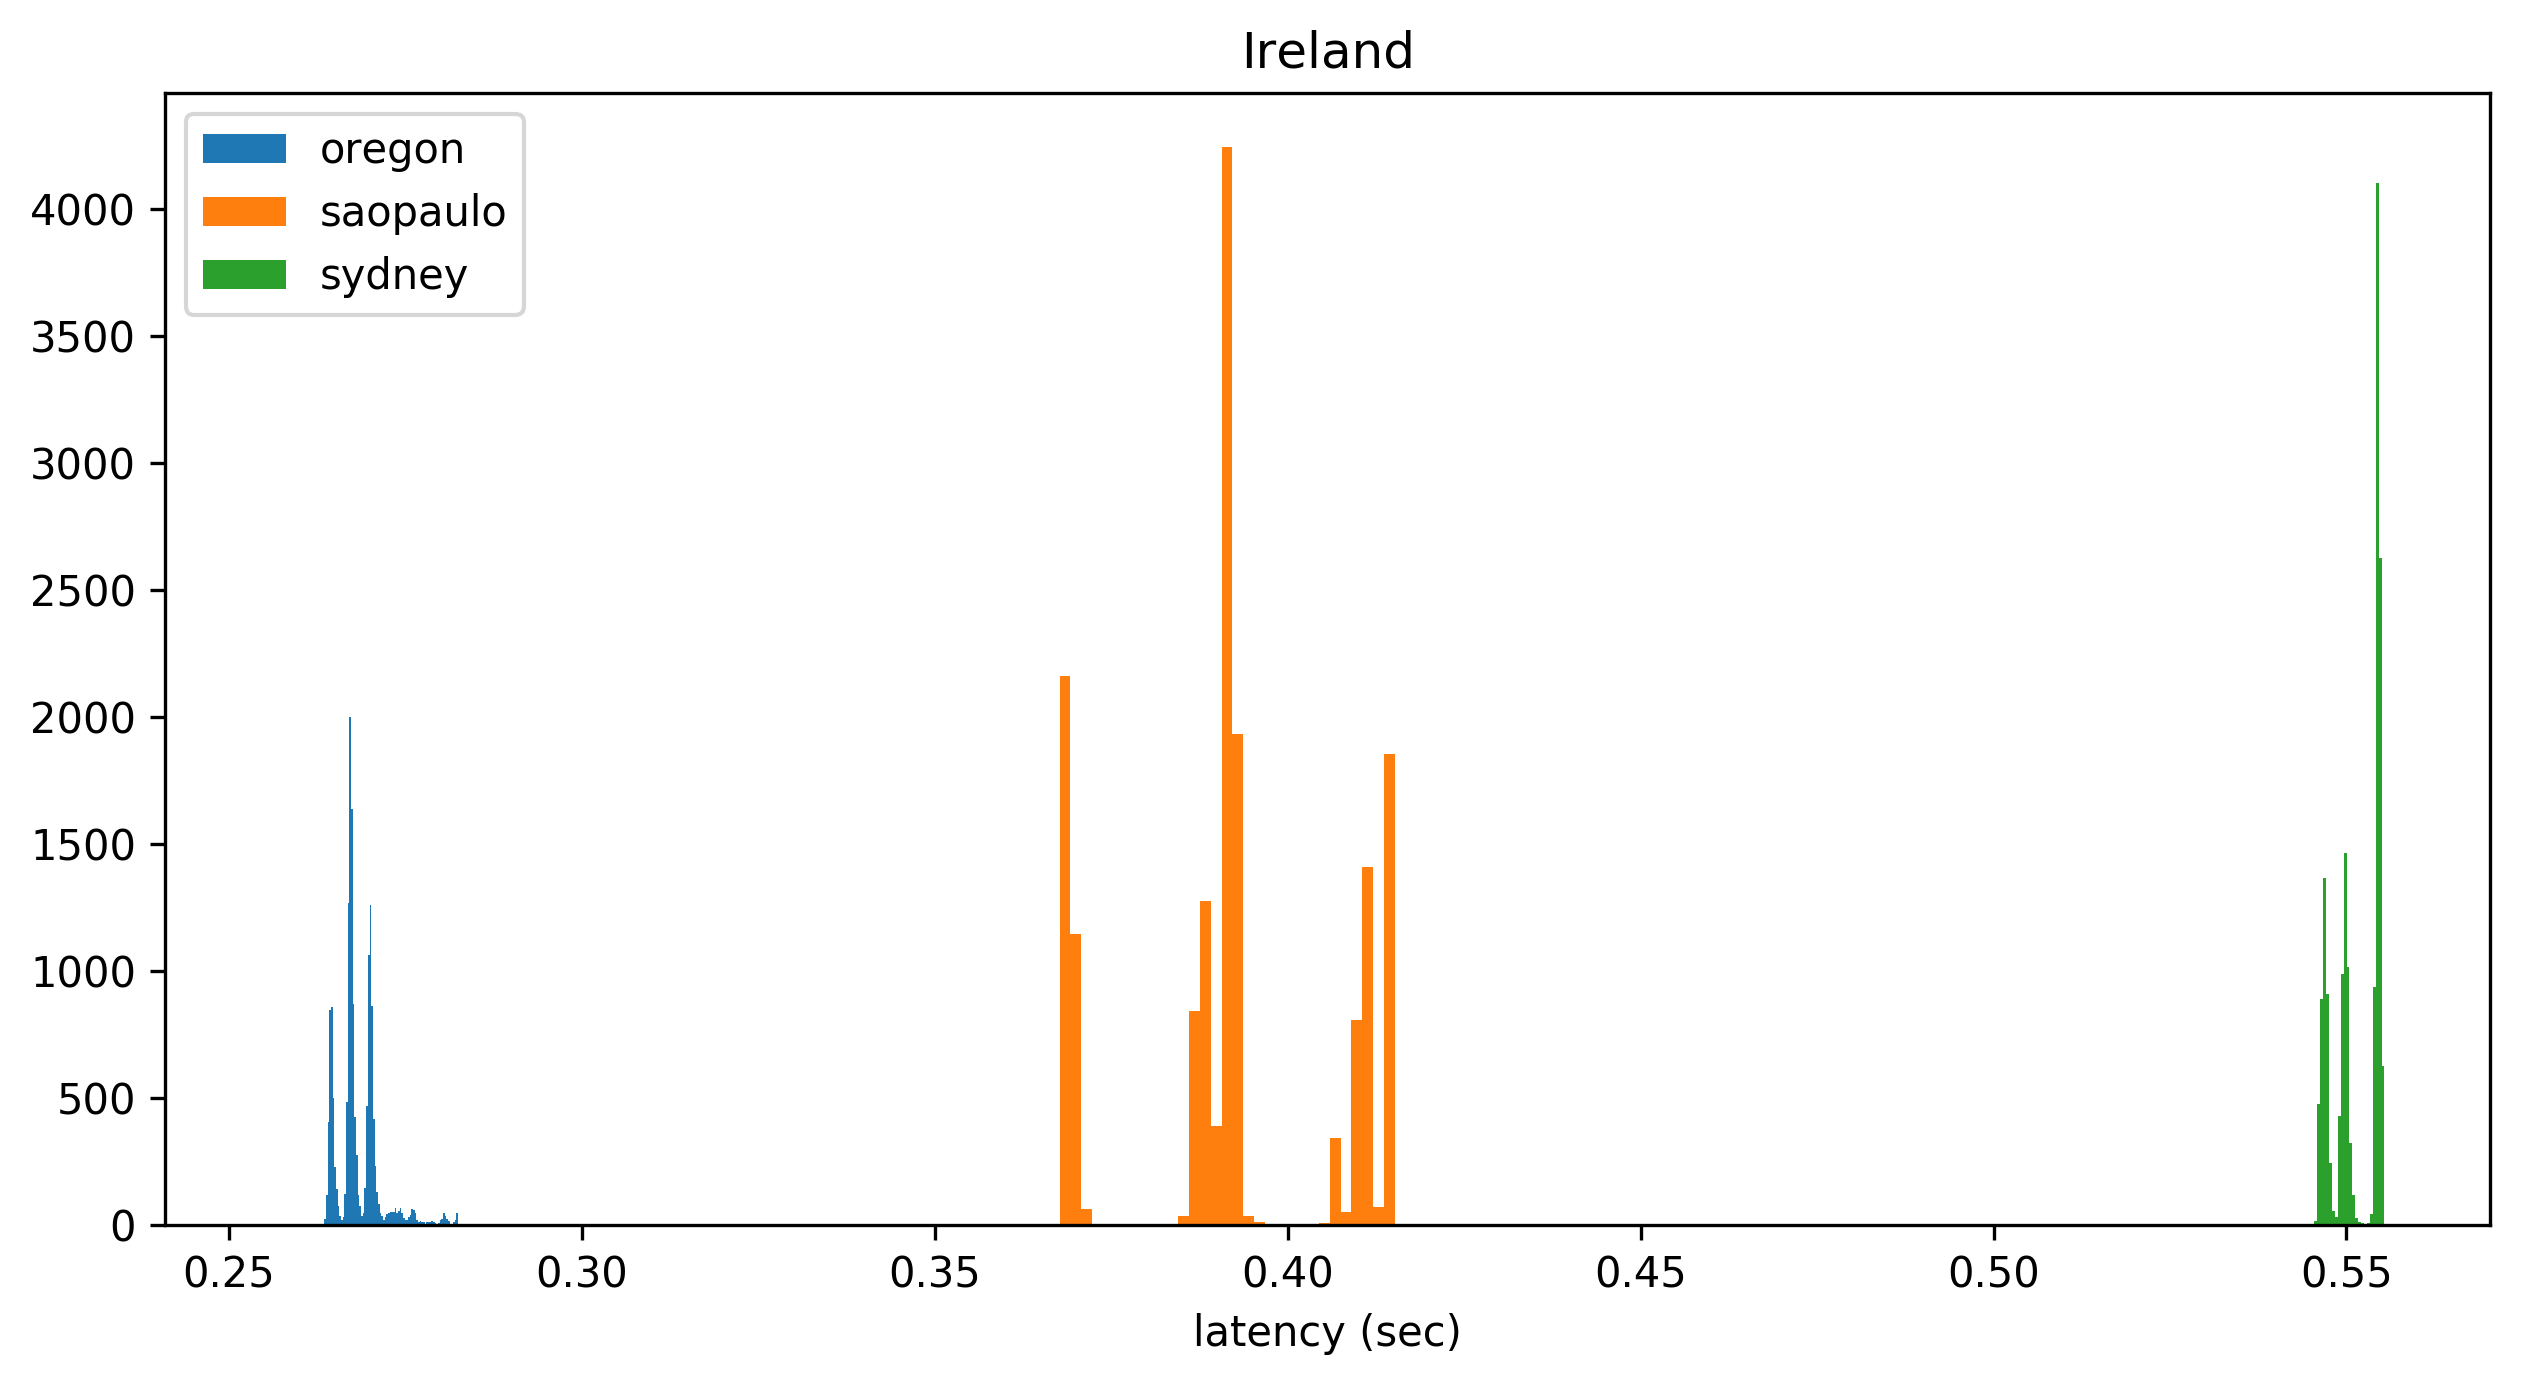

In [138]:
plt.hist(df95Grouped.get_group(('ireland','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('ireland','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.hist(df95Grouped.get_group(('ireland','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.title("Ireland")
plt.xlabel('latency (sec)')
plt.legend()

### Oregon

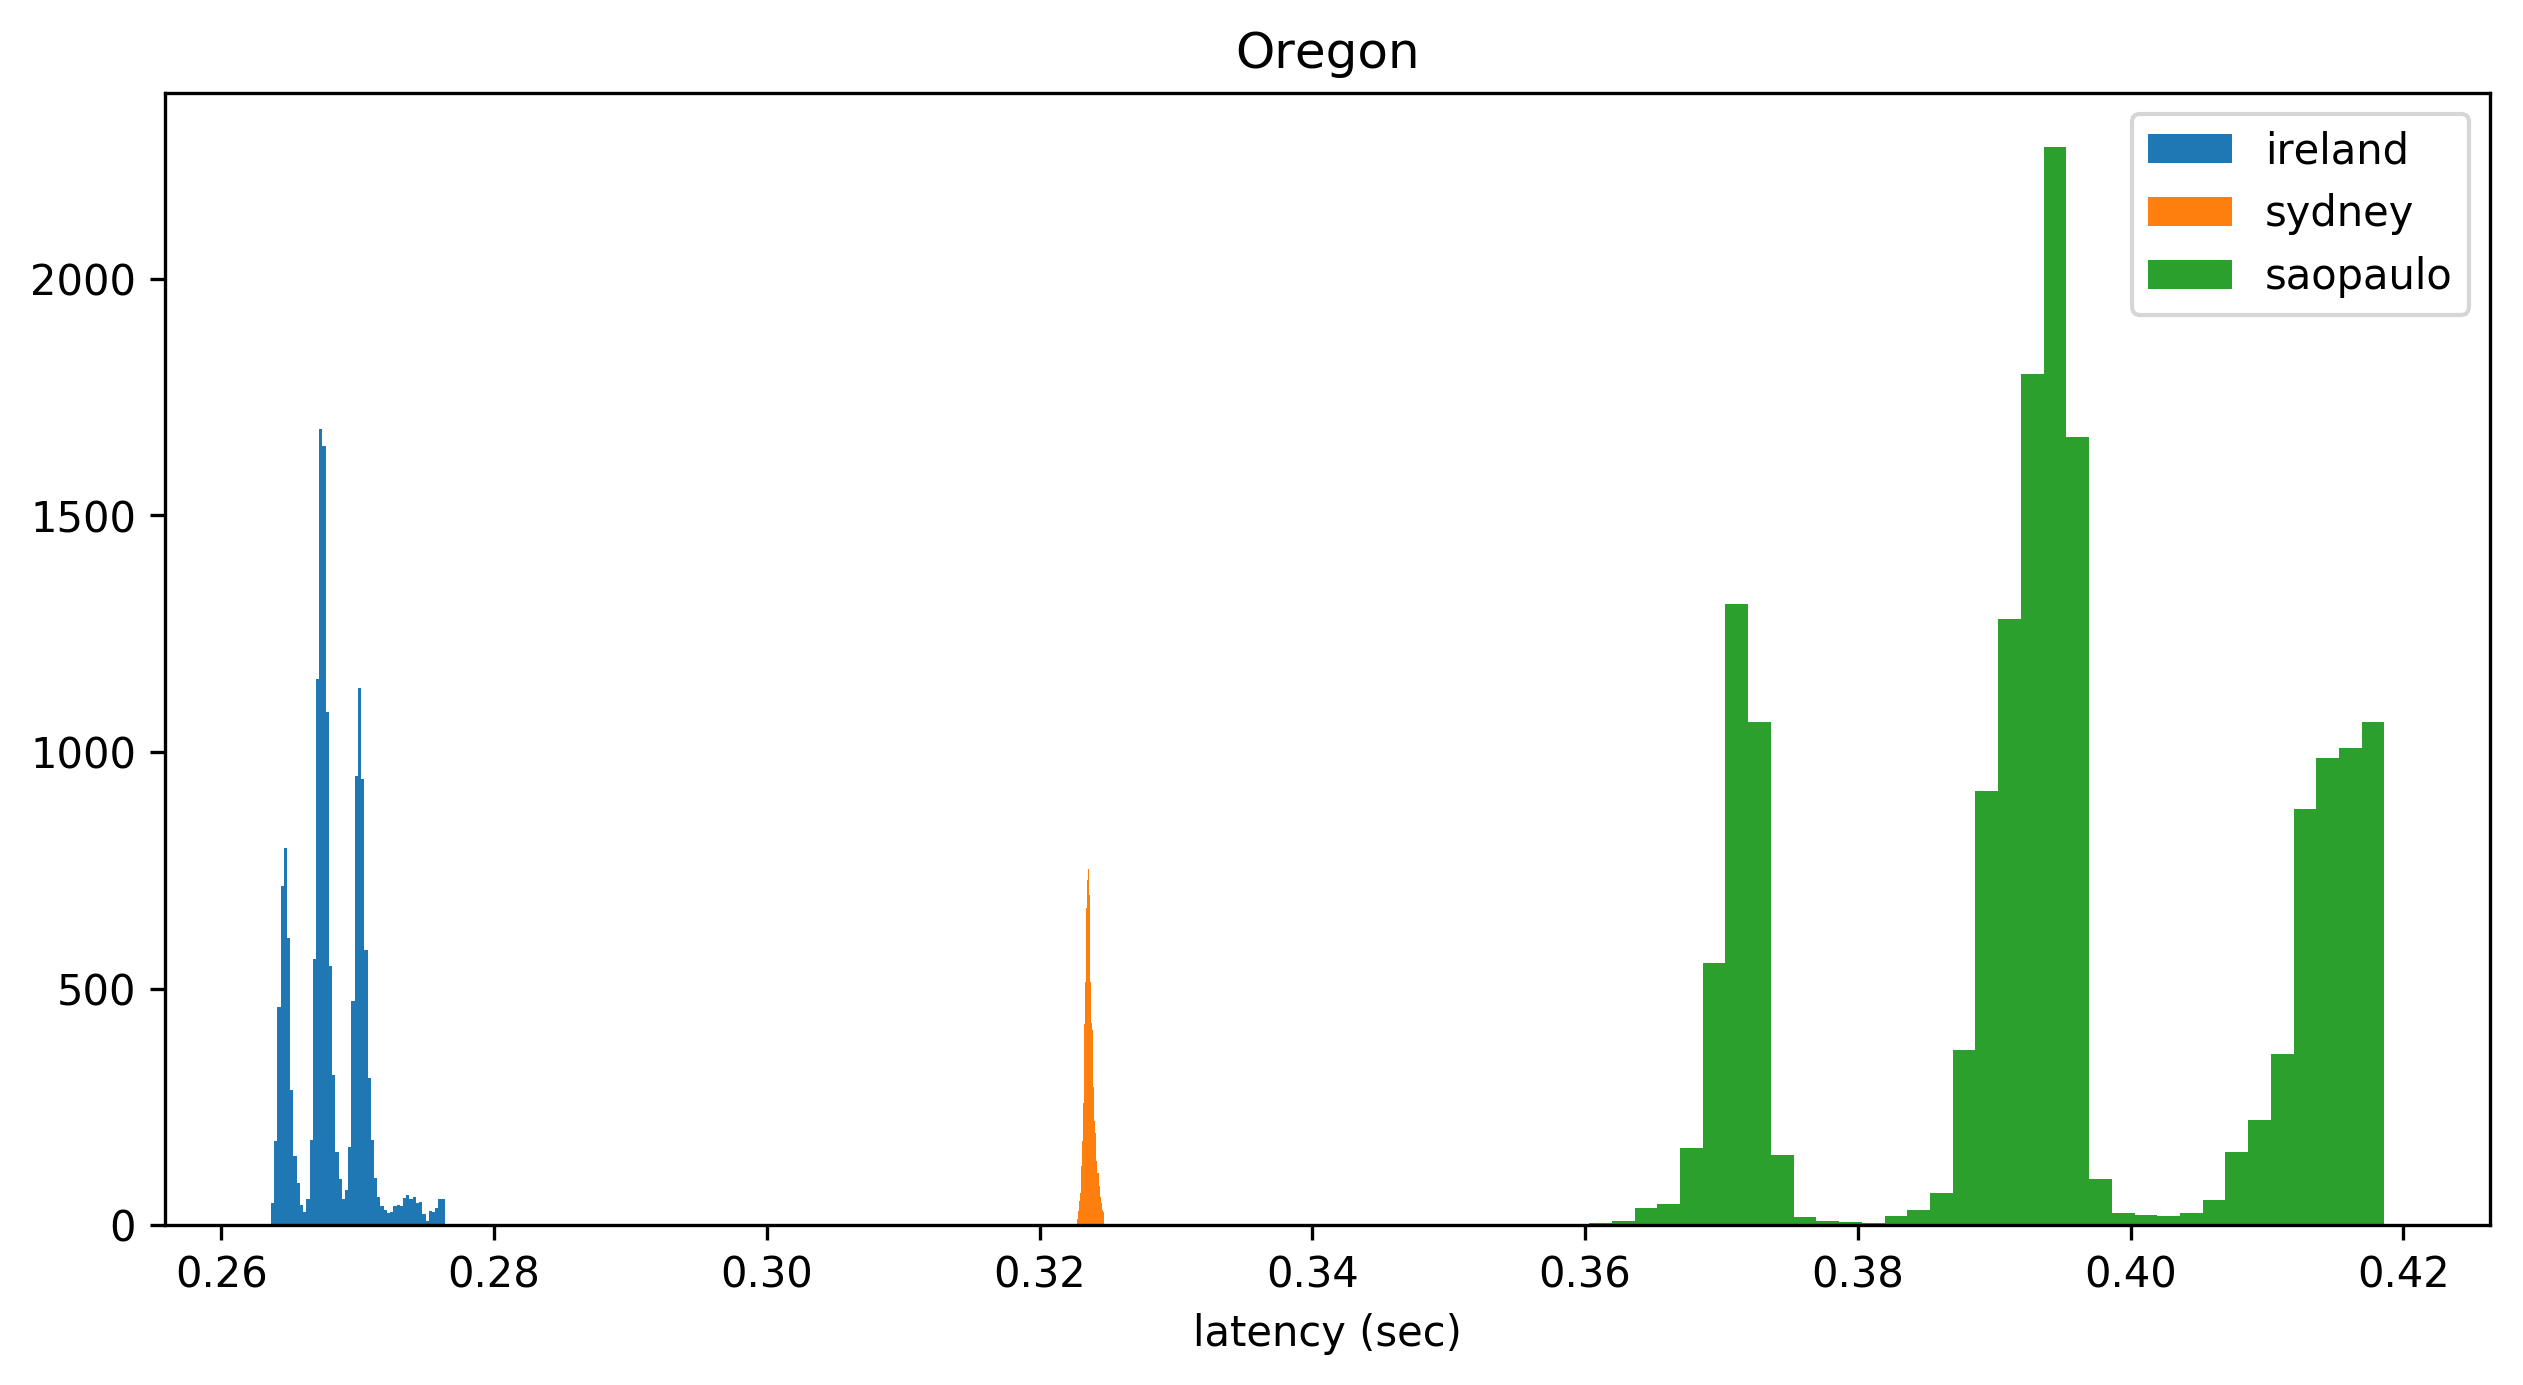

In [140]:
plt.hist(df95Grouped.get_group(('oregon','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('oregon','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.hist(df95Grouped.get_group(('oregon','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.title("Oregon")
plt.xlabel('latency (sec)')
plt.legend()

### Sao Paulo

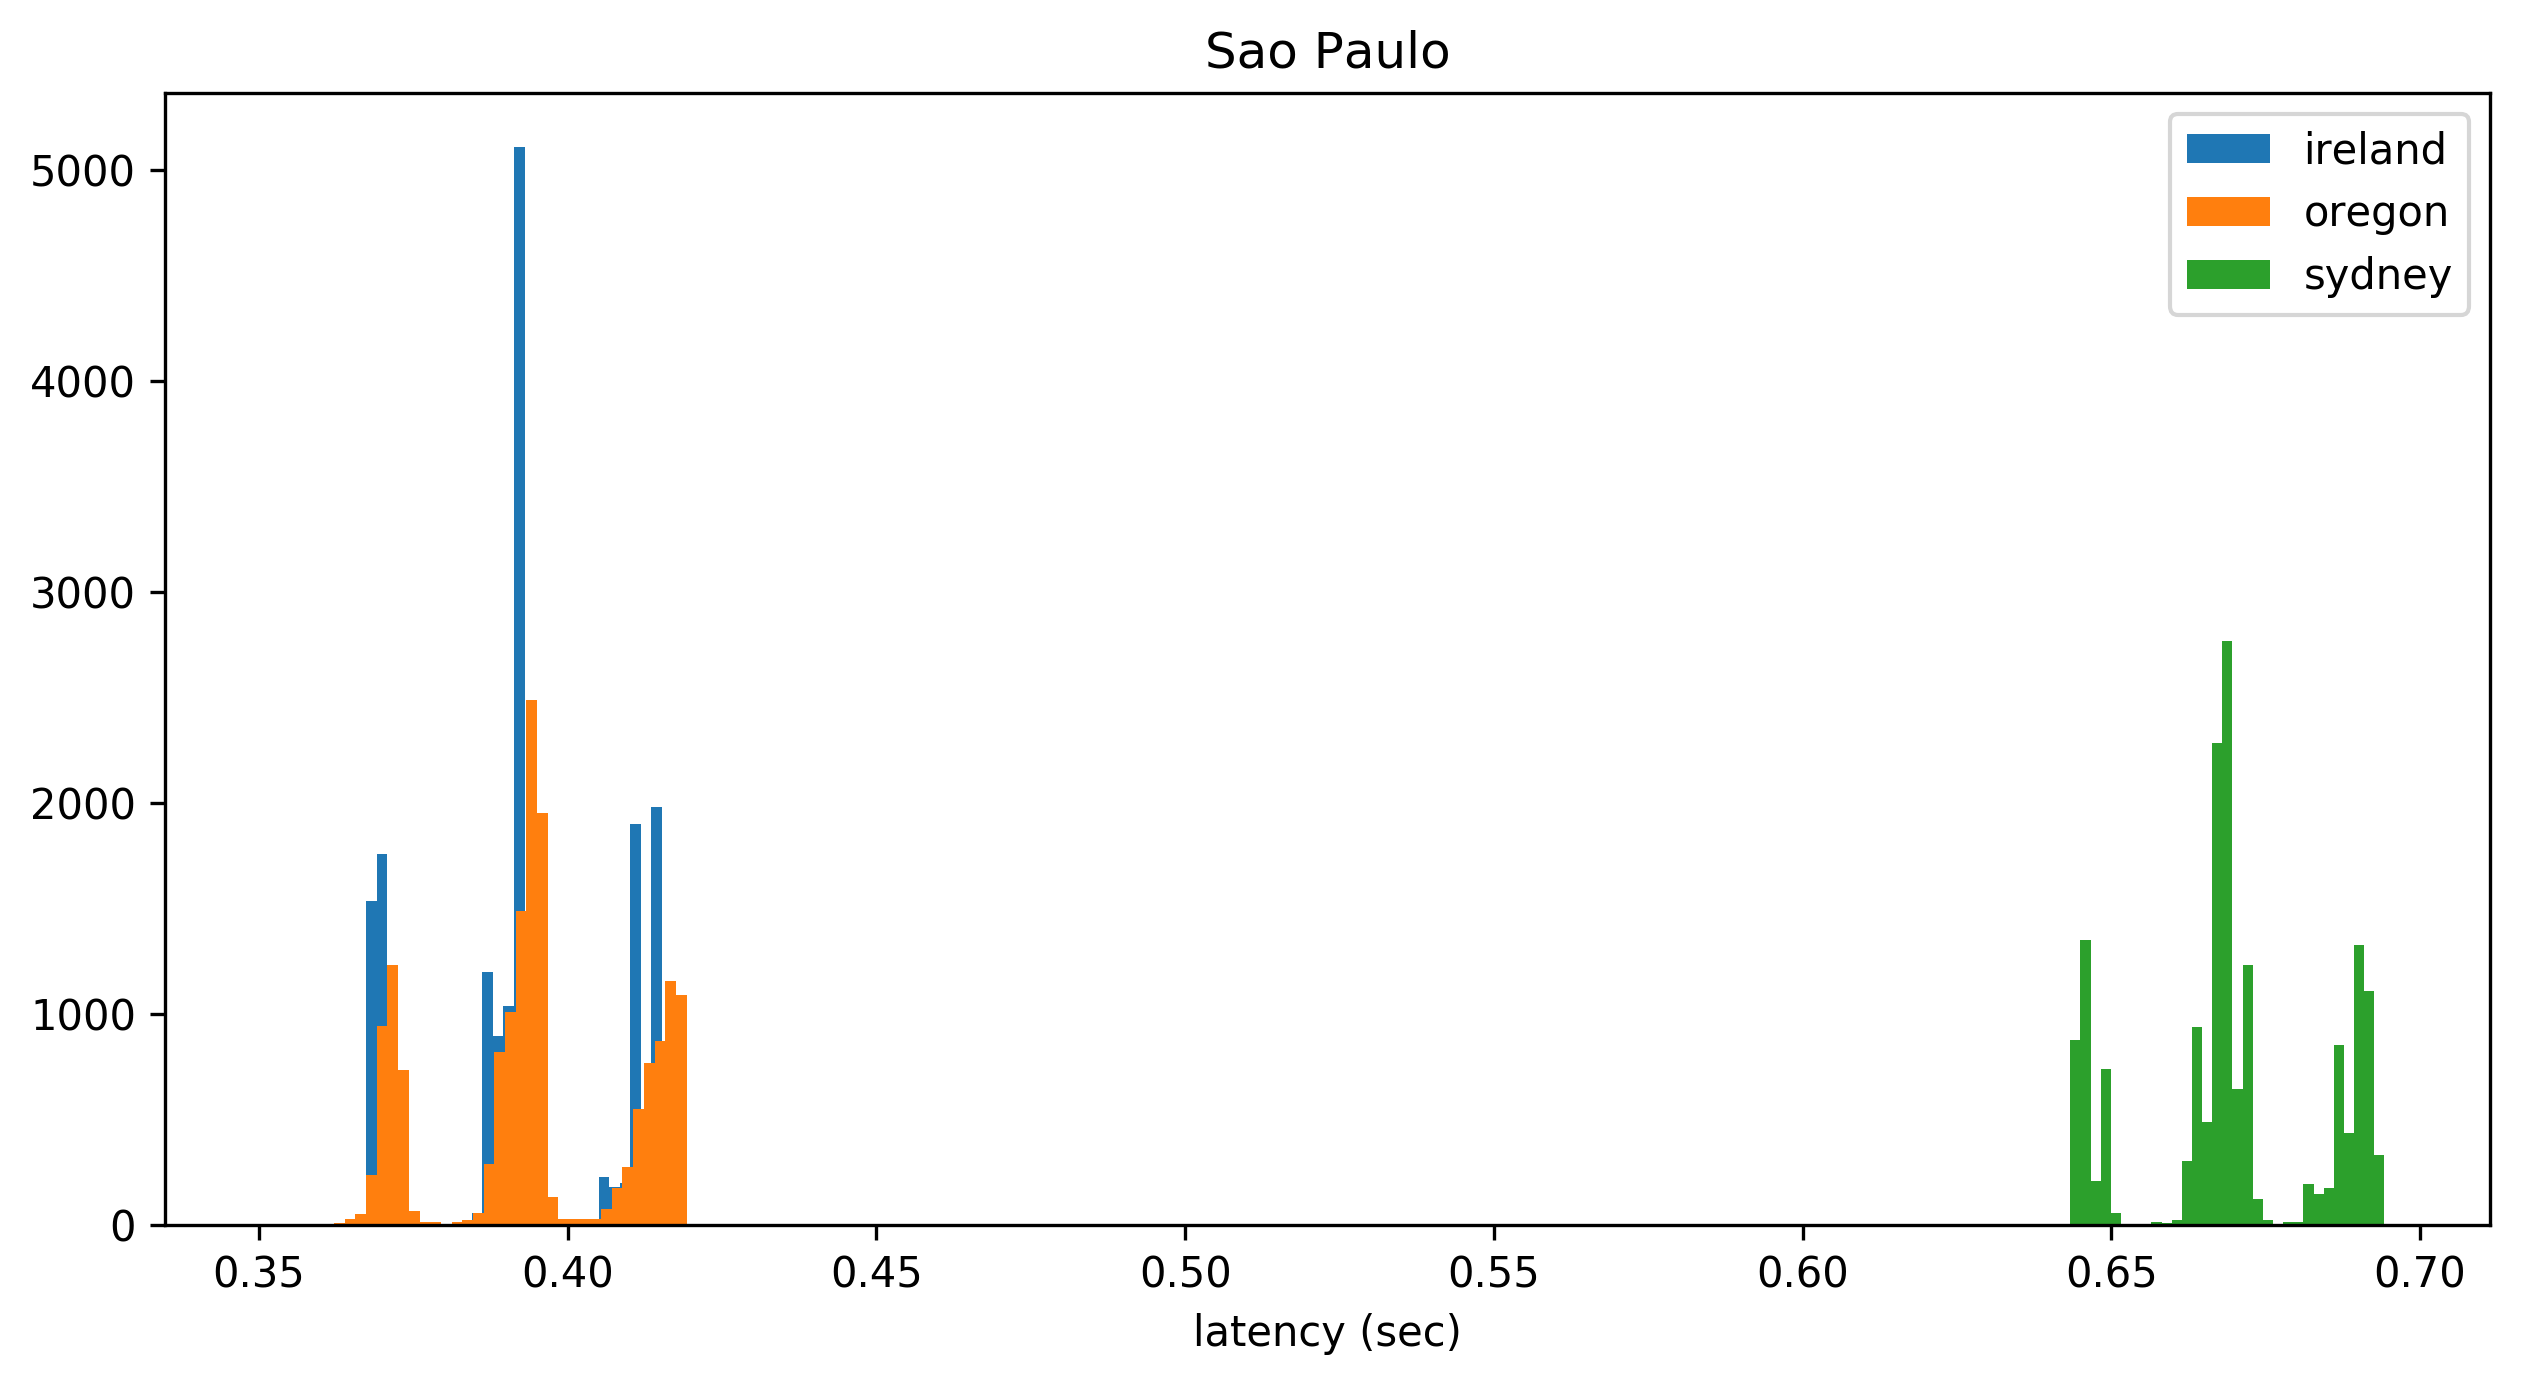

In [142]:
plt.hist(df95Grouped.get_group(('saopaulo','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('saopaulo','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('saopaulo','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.title("Sao Paulo")
plt.xlabel('latency (sec)')
plt.legend()

### Sydney

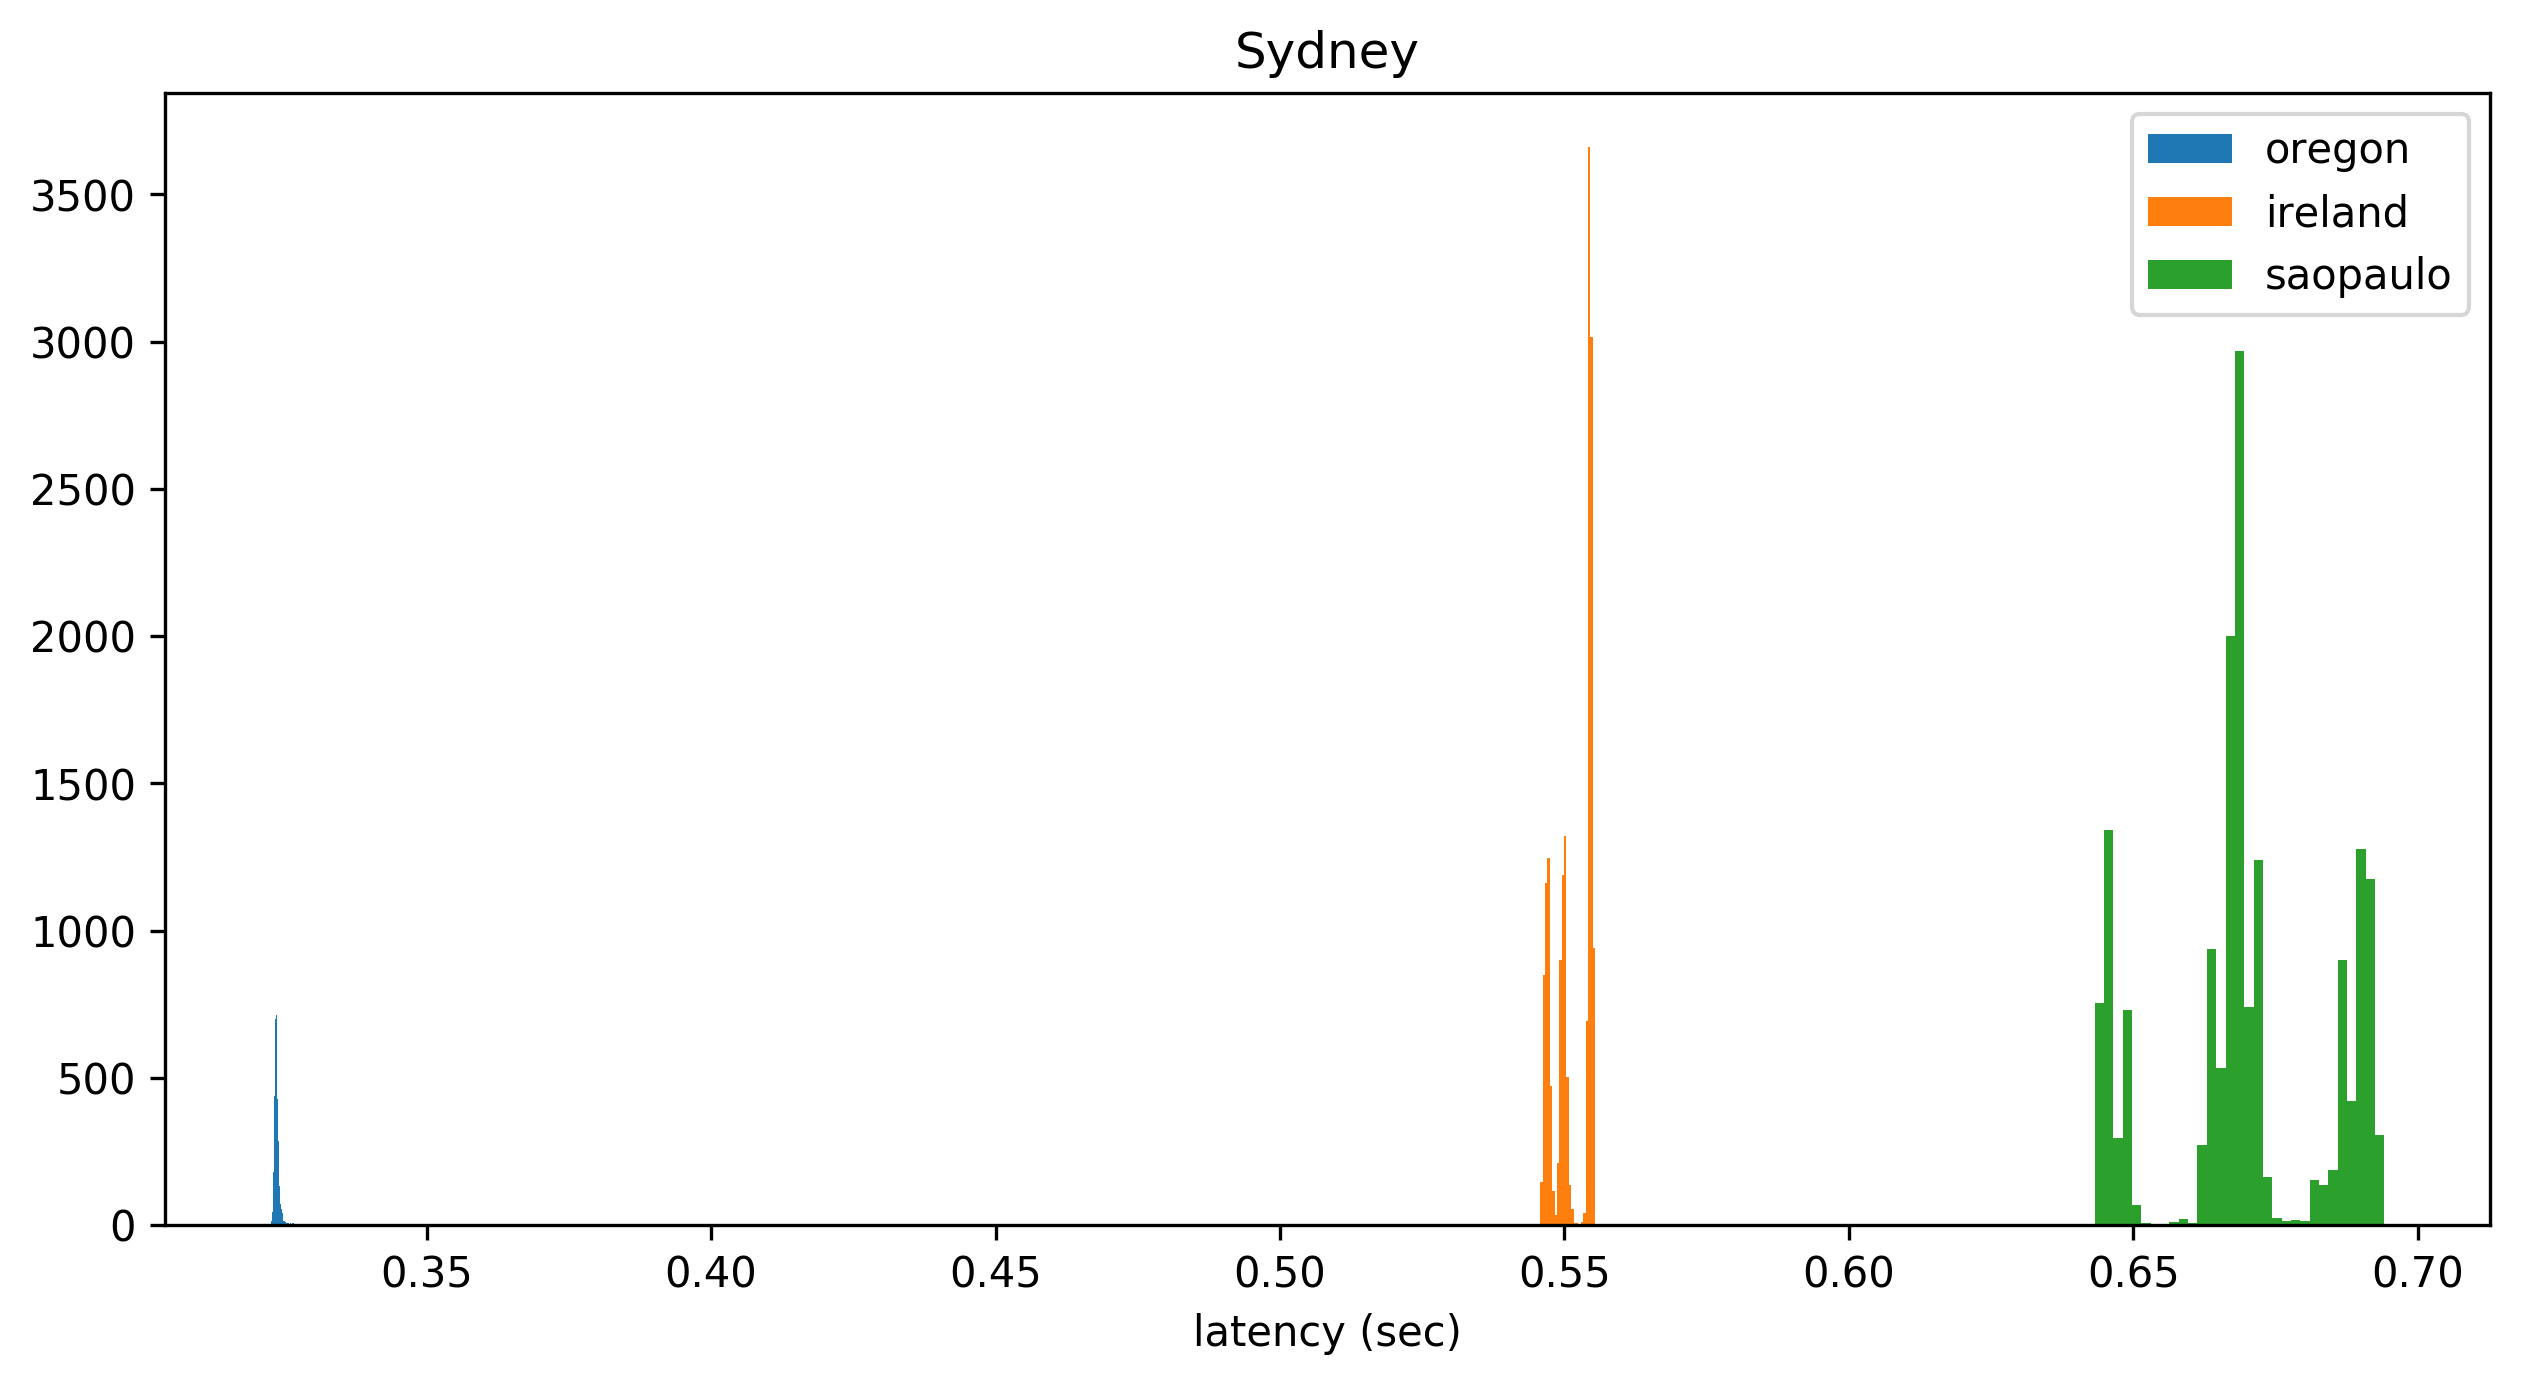

In [144]:
plt.hist(df95Grouped.get_group(('sydney','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('sydney','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('sydney','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.title("Sydney")
plt.xlabel('latency (sec)')
plt.legend()

===============================================================
===============================================================

## Time series analysis

In [105]:
df_ts = df.set_index('created_at')
df95_ts = df95.set_index('created_at')
df_ts_grouped = df_ts.groupby(['origin','destination'])
df95_ts_grouped = df95_ts.groupby(['origin','destination'])

In [118]:
iolatency = df_ts_grouped.get_group(('ireland','oregon'))['latency']
isaolatency = df_ts_grouped.get_group(('ireland','saopaulo'))['latency']
isydlatency = df_ts_grouped.get_group(('ireland','sydney'))['latency']

oilatency = df_ts_grouped.get_group(('oregon','ireland'))['latency']
osaolatency = df_ts_grouped.get_group(('oregon','saopaulo'))['latency']
osydlatency = df_ts_grouped.get_group(('oregon','sydney'))['latency']

saoreglatency = df_ts_grouped.get_group(('saopaulo','oregon'))['latency']
saoilatency = df_ts_grouped.get_group(('saopaulo','ireland'))['latency']
saosydlatency = df_ts_grouped.get_group(('saopaulo','sydney'))['latency']

sydolatency = df_ts_grouped.get_group(('sydney','oregon'))['latency']
sydsaolatency = df_ts_grouped.get_group(('sydney','saopaulo'))['latency']
sydilatency = df_ts_grouped.get_group(('sydney','ireland'))['latency']

iolatency95 = df95_ts_grouped.get_group(('ireland','oregon'))['latency']

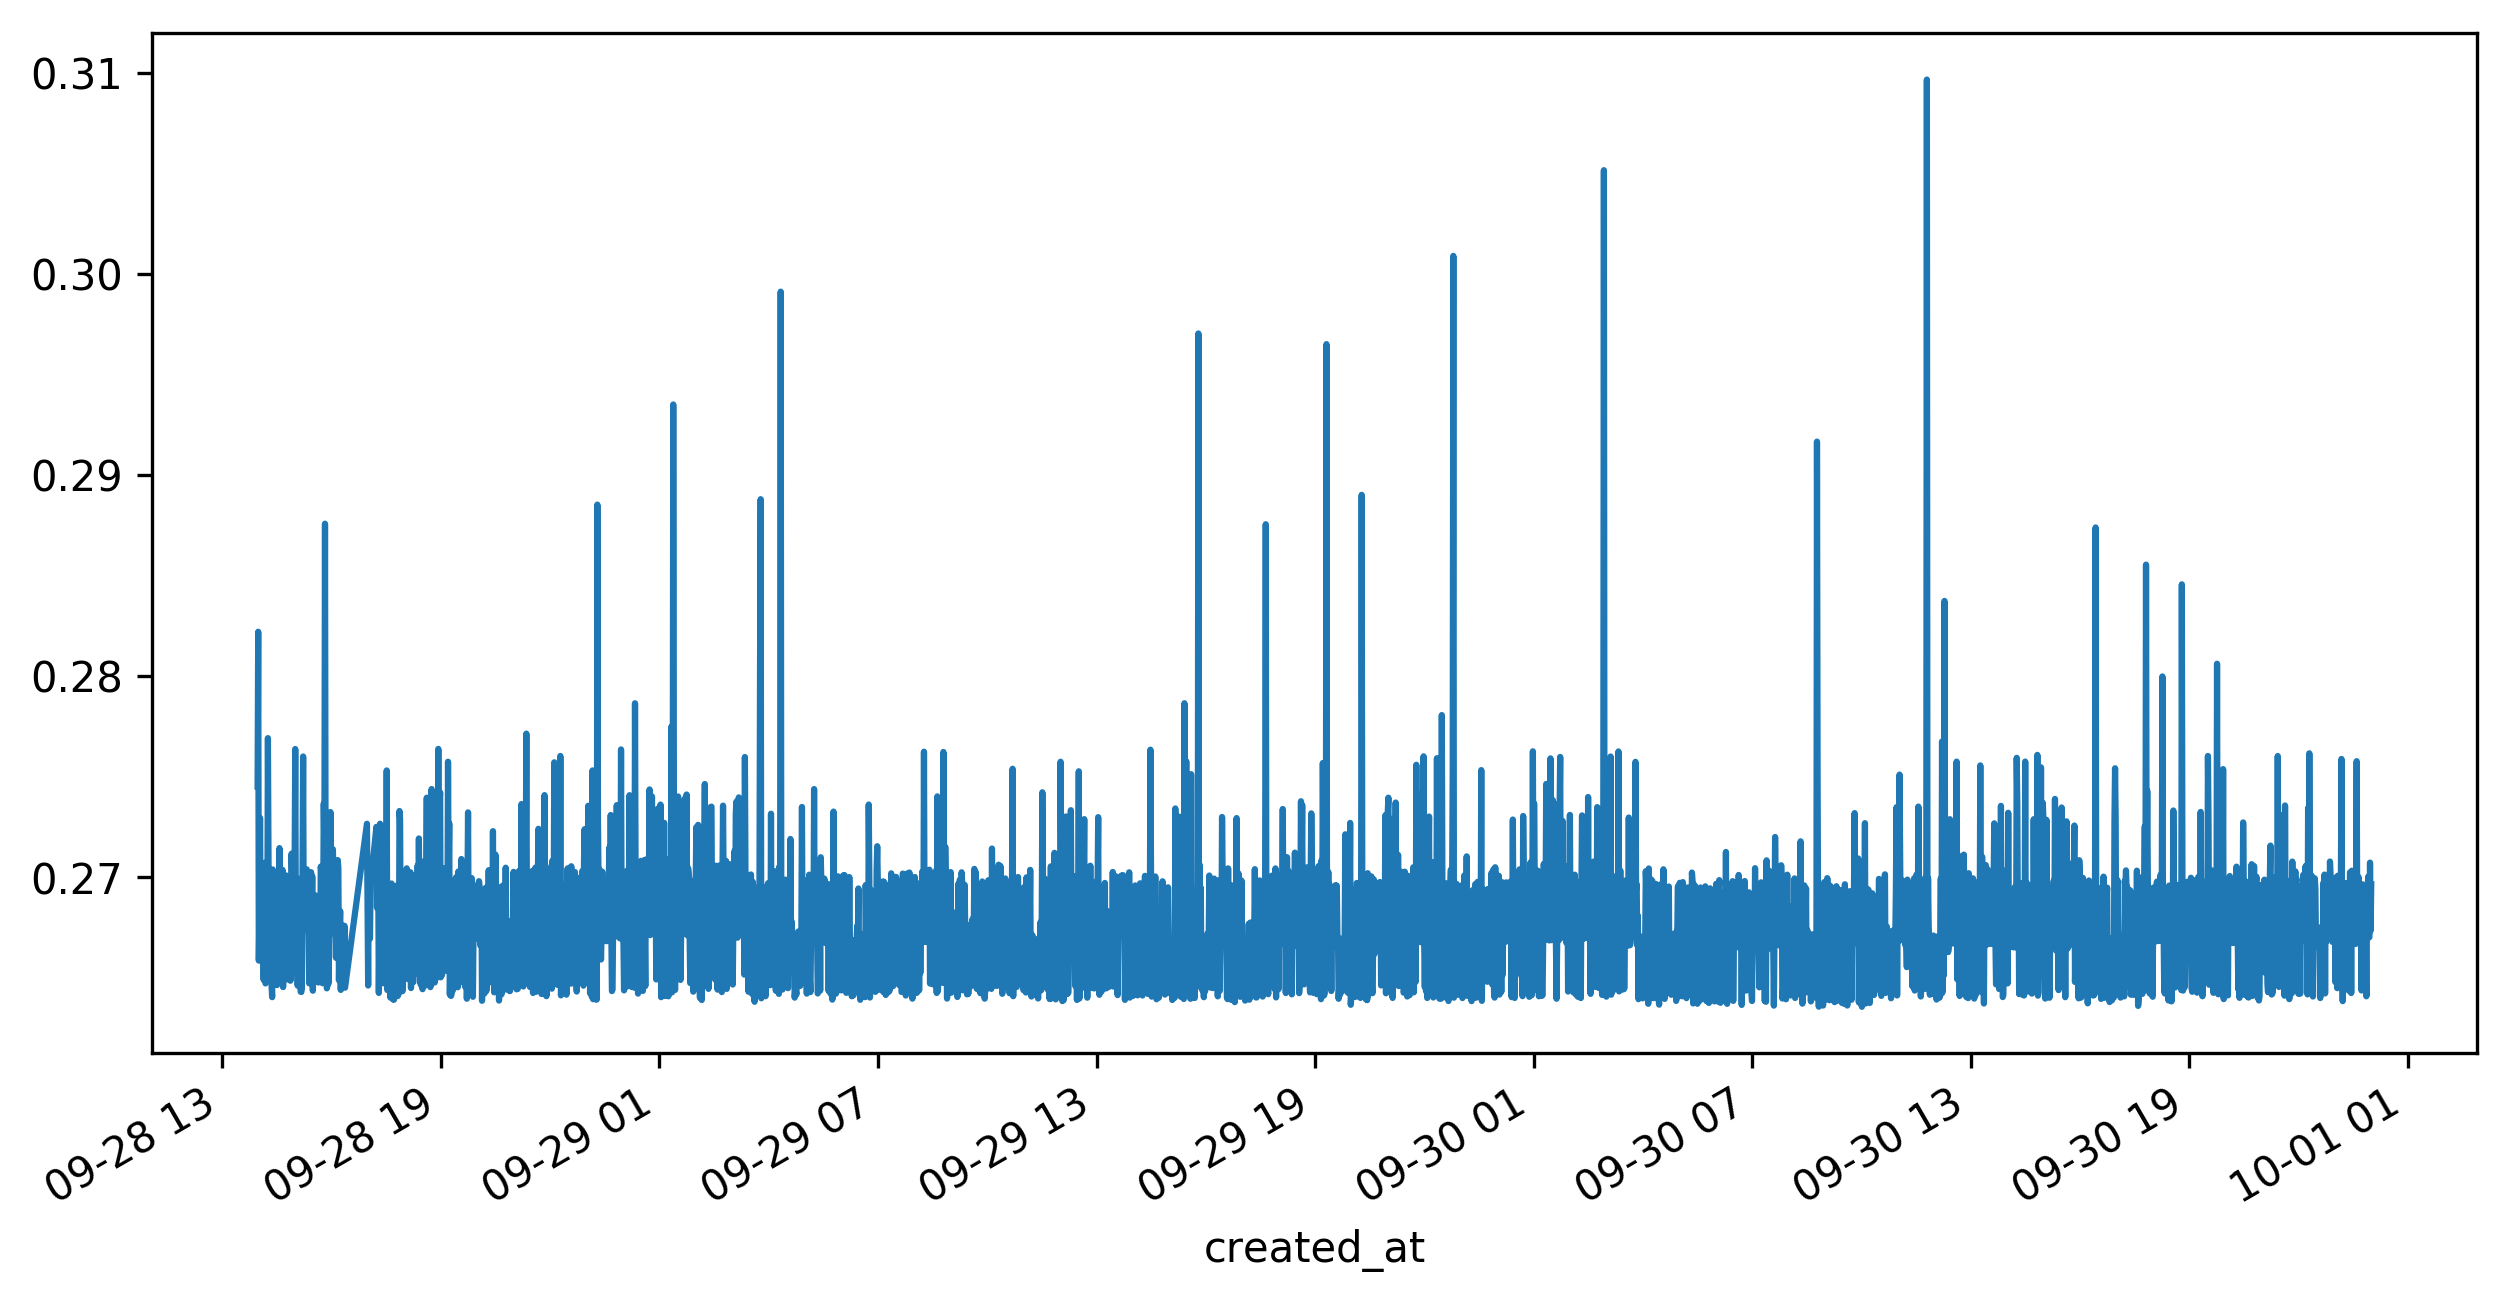

In [107]:
iolatency['2018-09-28':'2018-09-30'].plot()

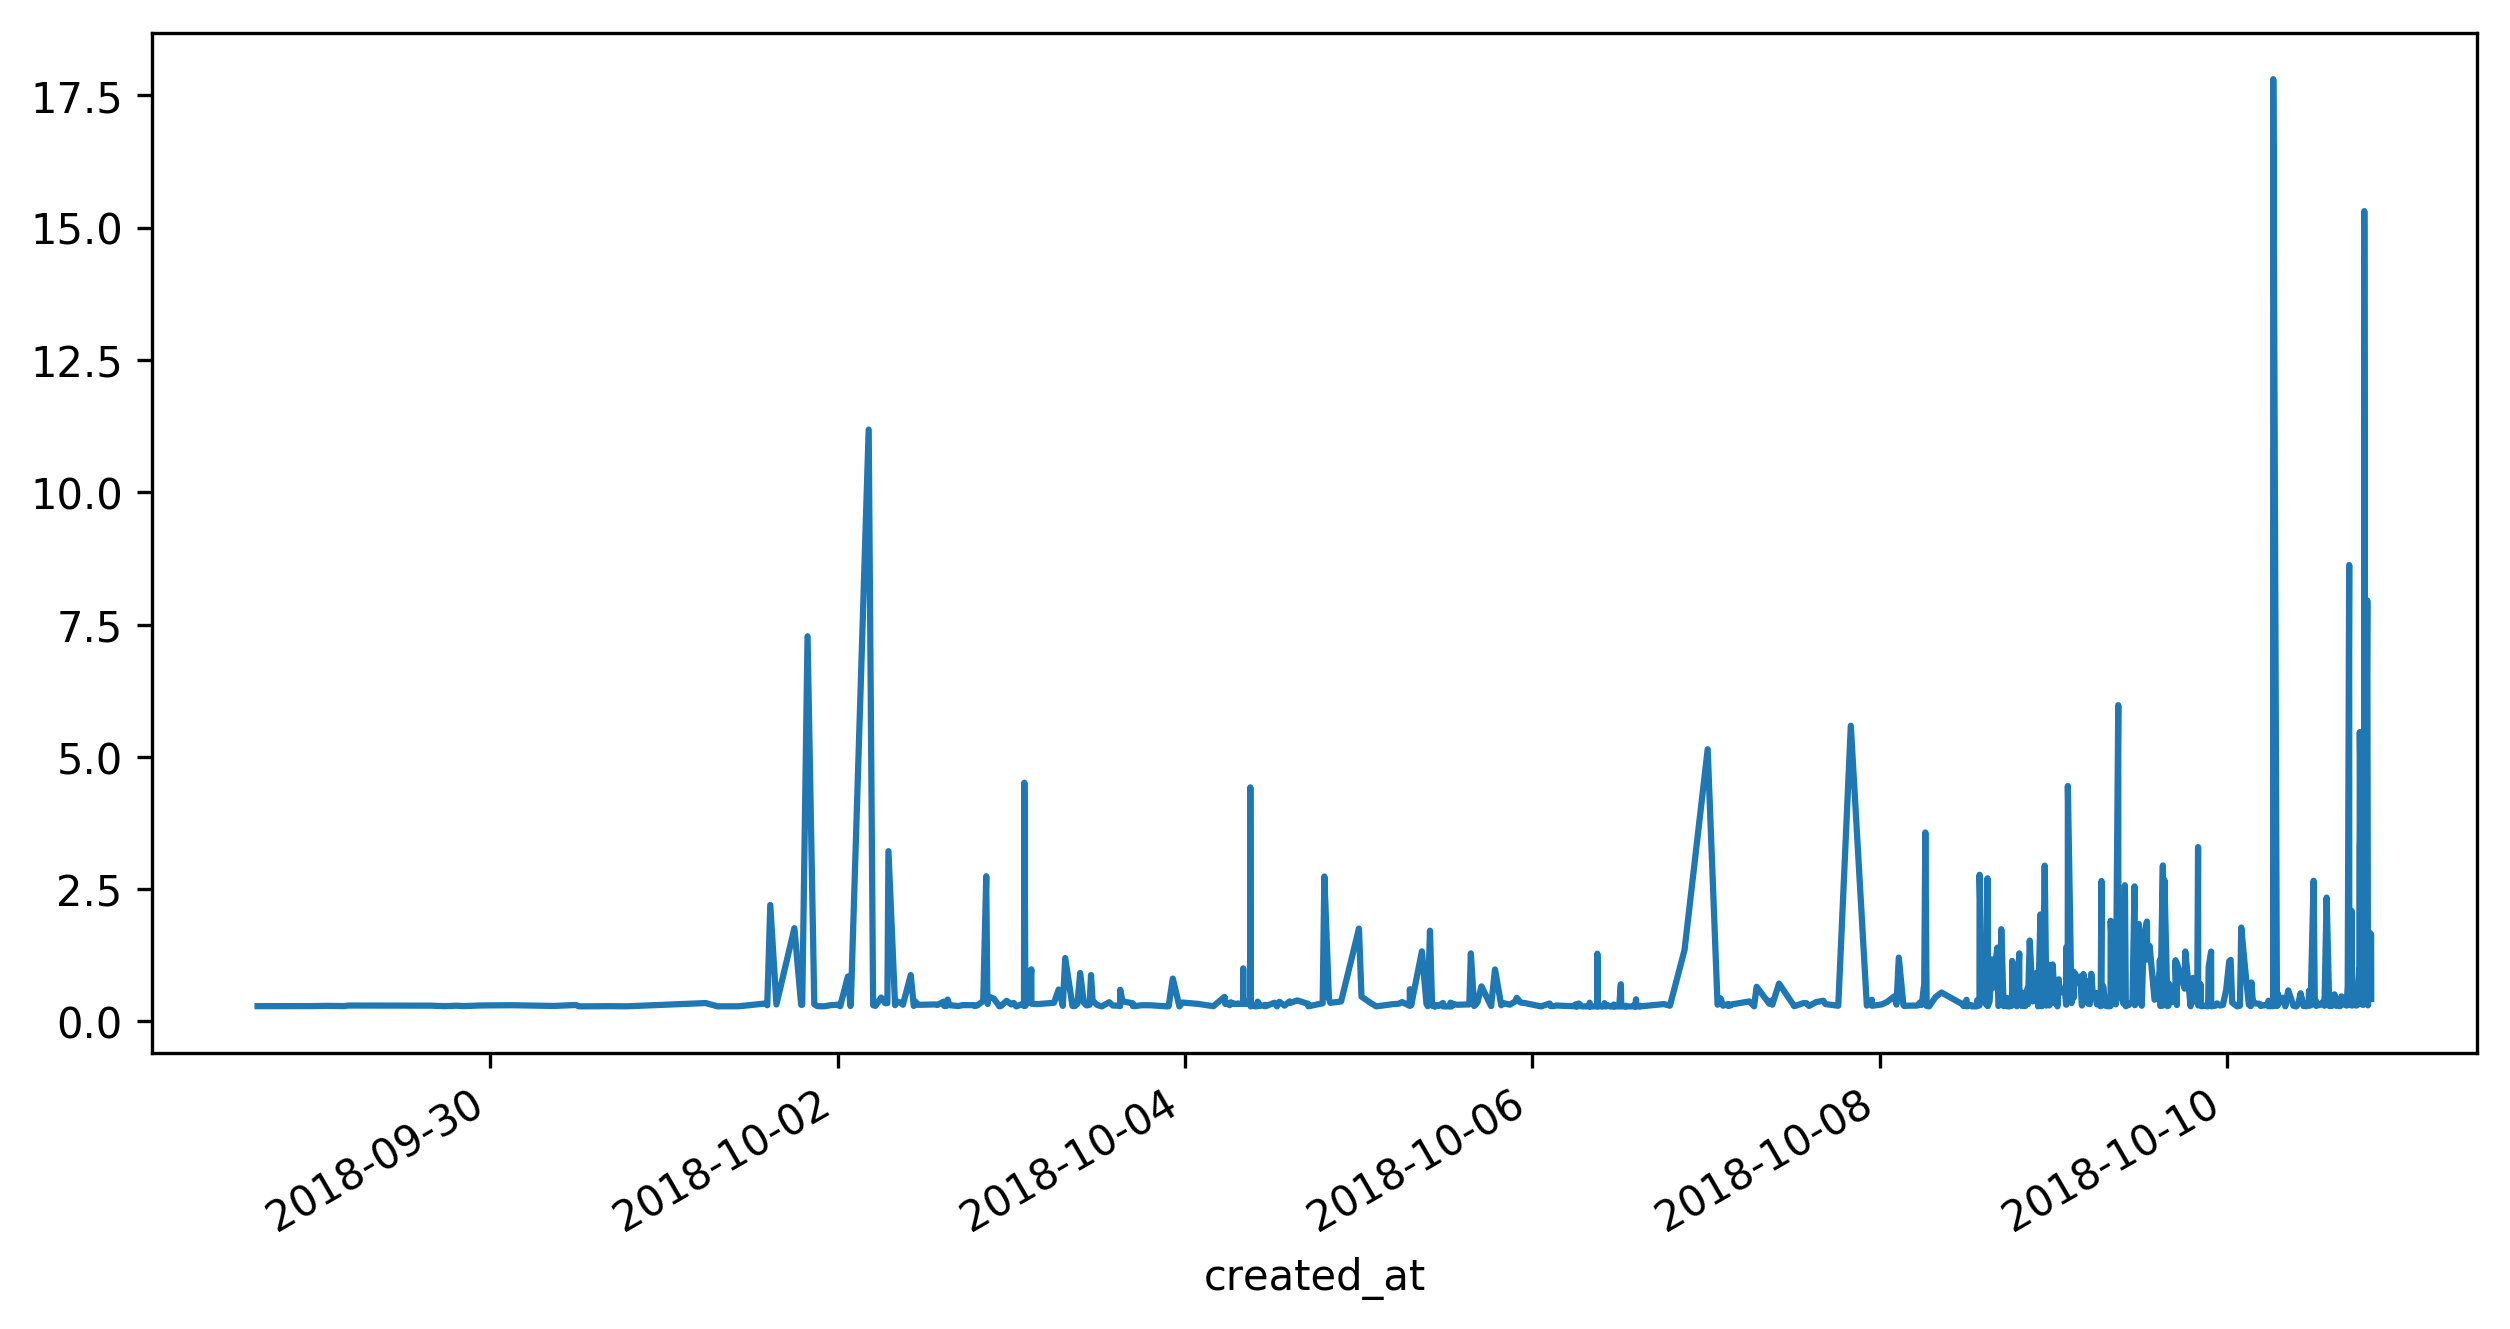

In [109]:
#outliers
iolatency[iolatency > statistics_df.loc[('ireland','oregon'),('latency','95%')]].plot()

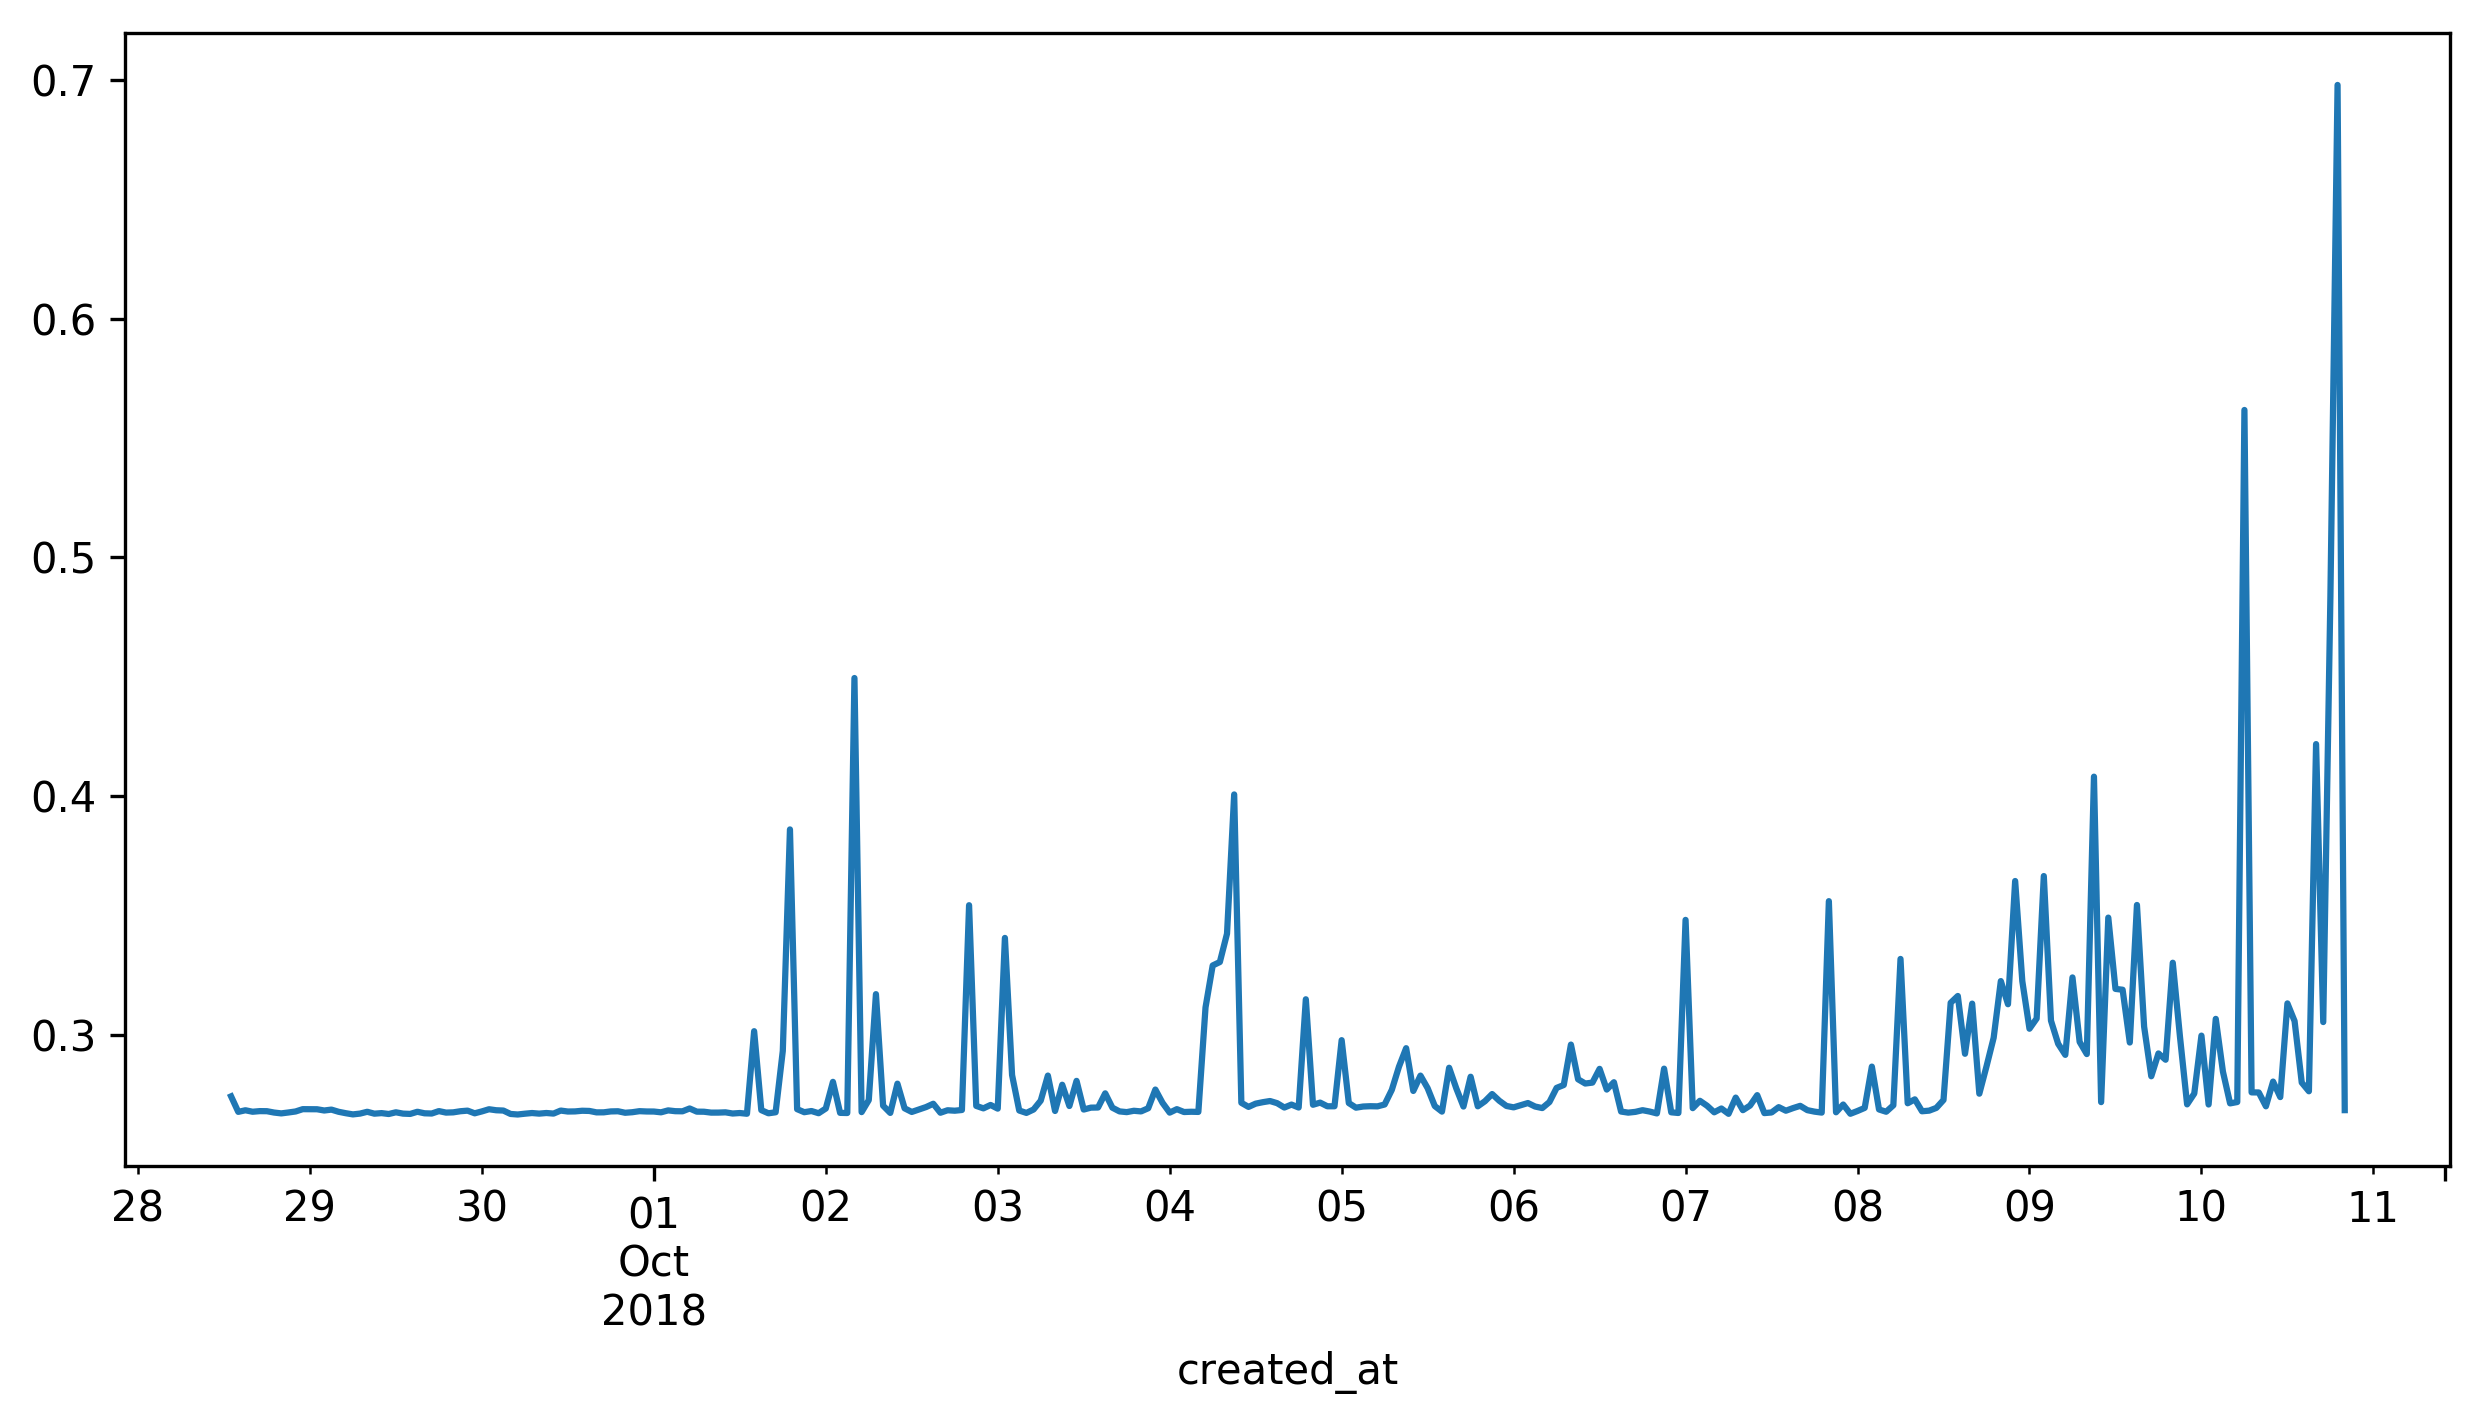

In [112]:
#resampling by hour
iolatency.resample('H').mean().plot()

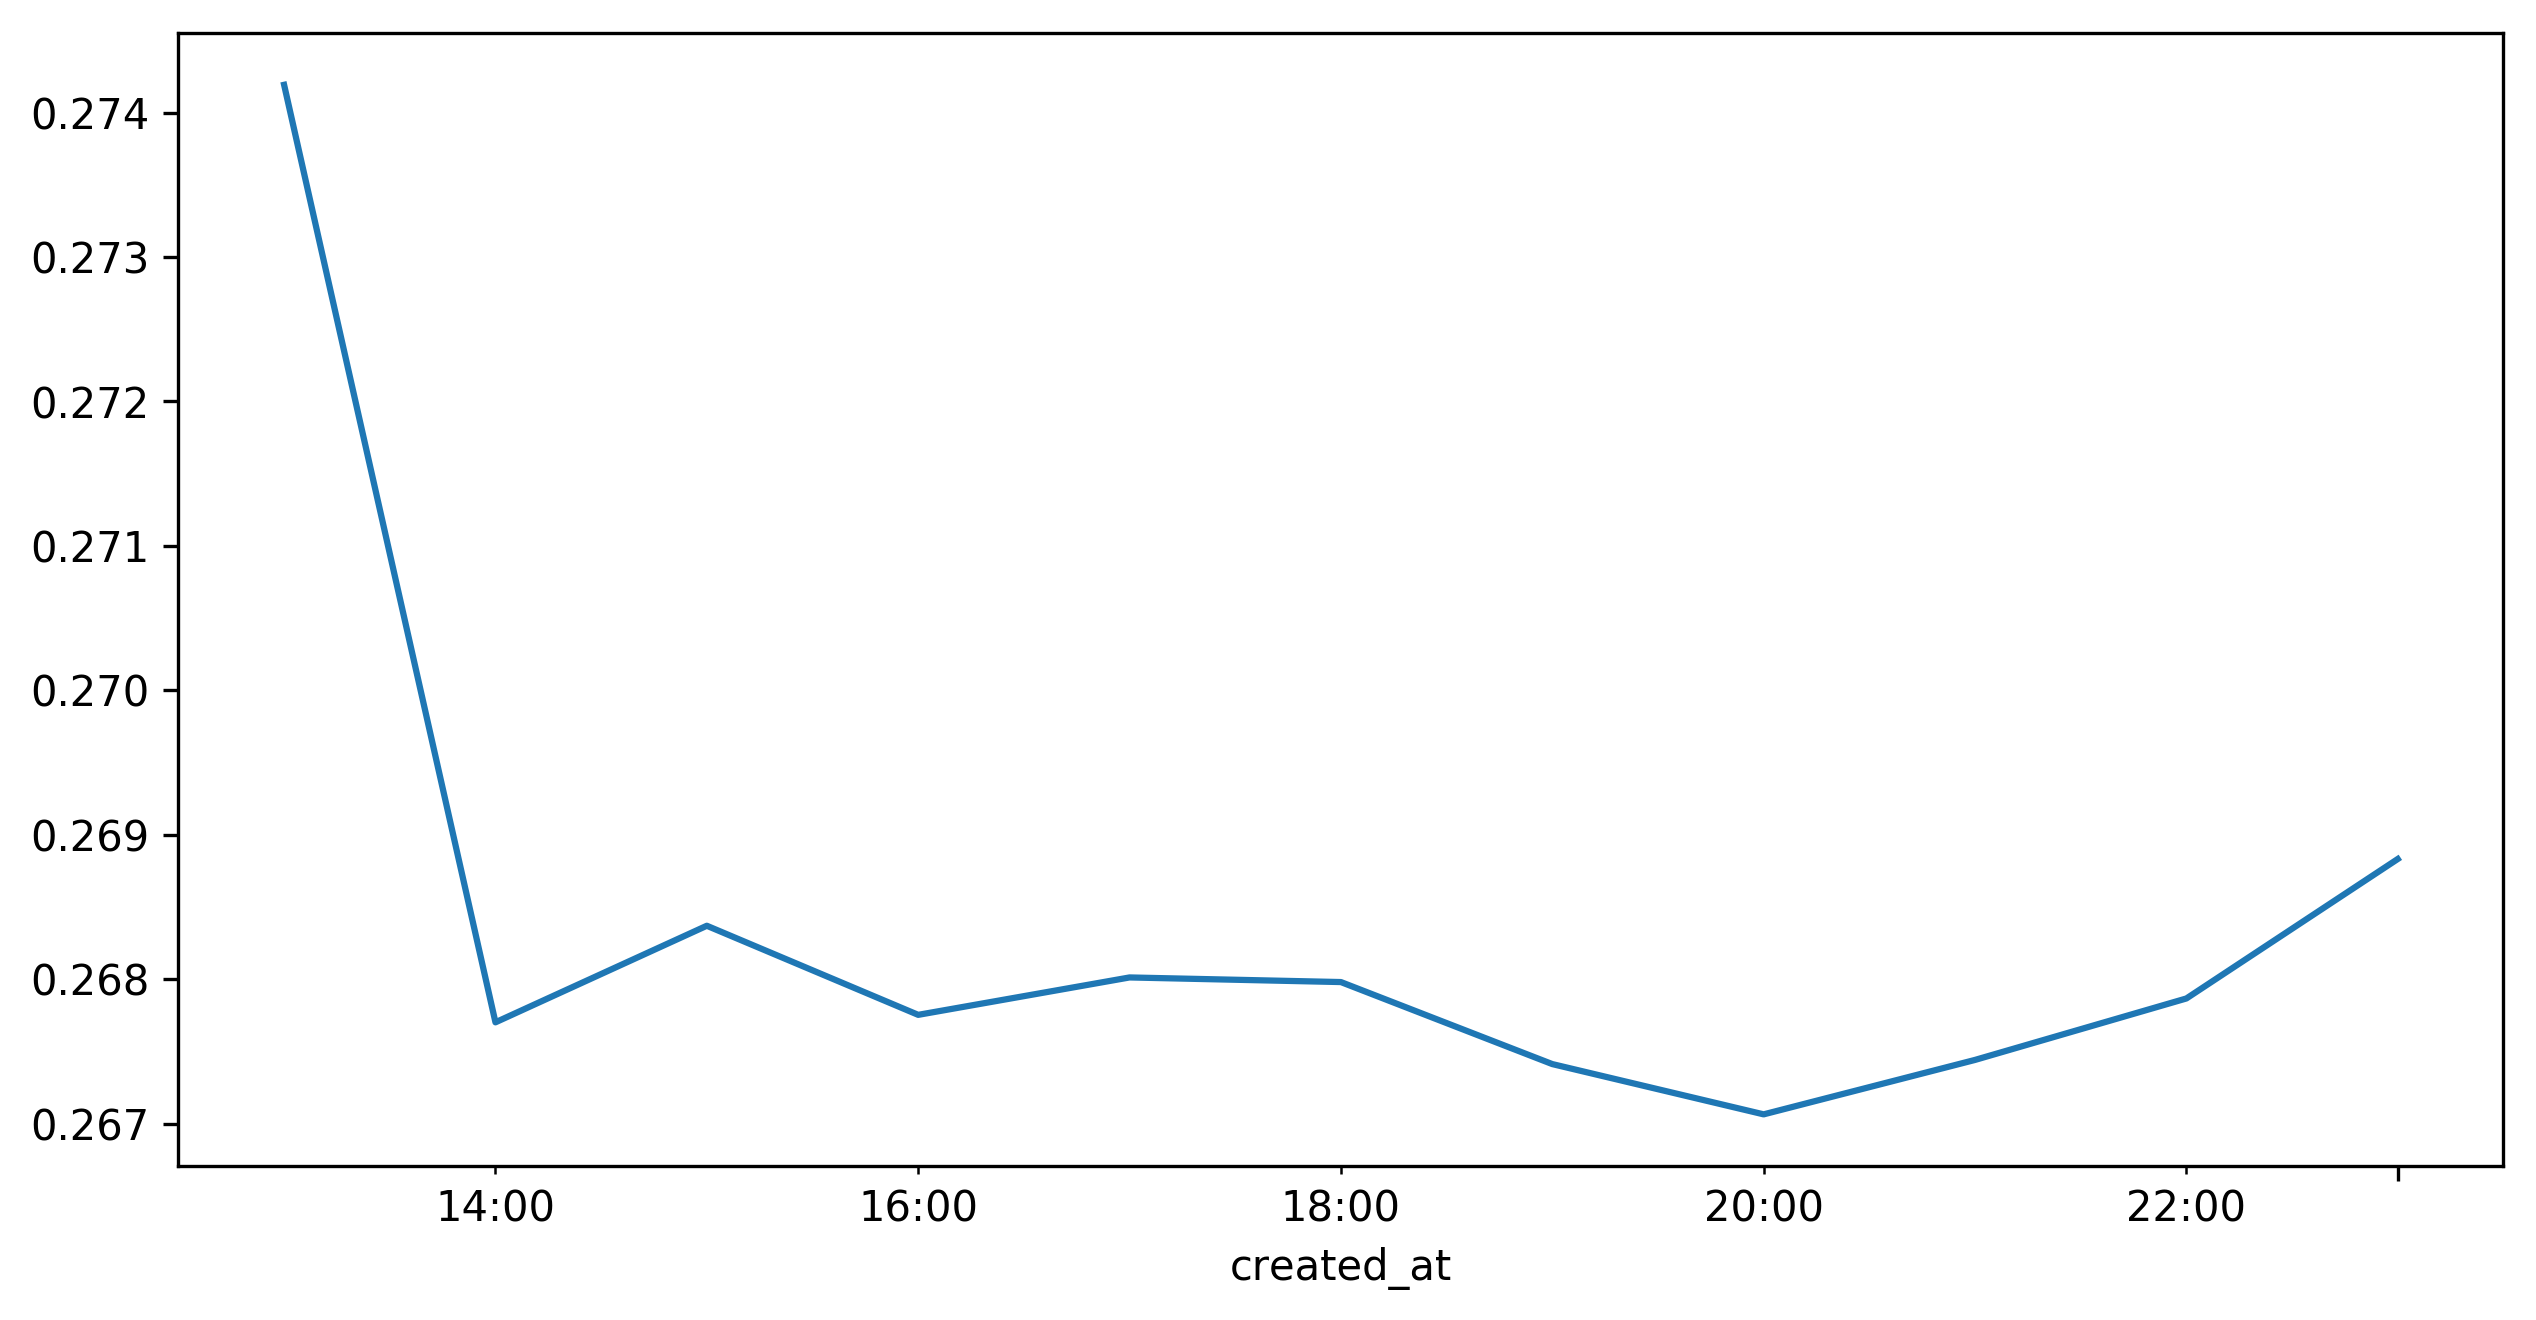

In [113]:
iolatency['28-9-2018'].resample('H').mean().plot()

In [114]:
rng = pd.date_range('28-9-2018', periods=13, freq='D')
rng

DatetimeIndex(['2018-09-28', '2018-09-29', '2018-09-30', '2018-10-01',
               '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
               '2018-10-06', '2018-10-07', '2018-10-08', '2018-10-09',
               '2018-10-10'],
              dtype='datetime64[ns]', freq='D')

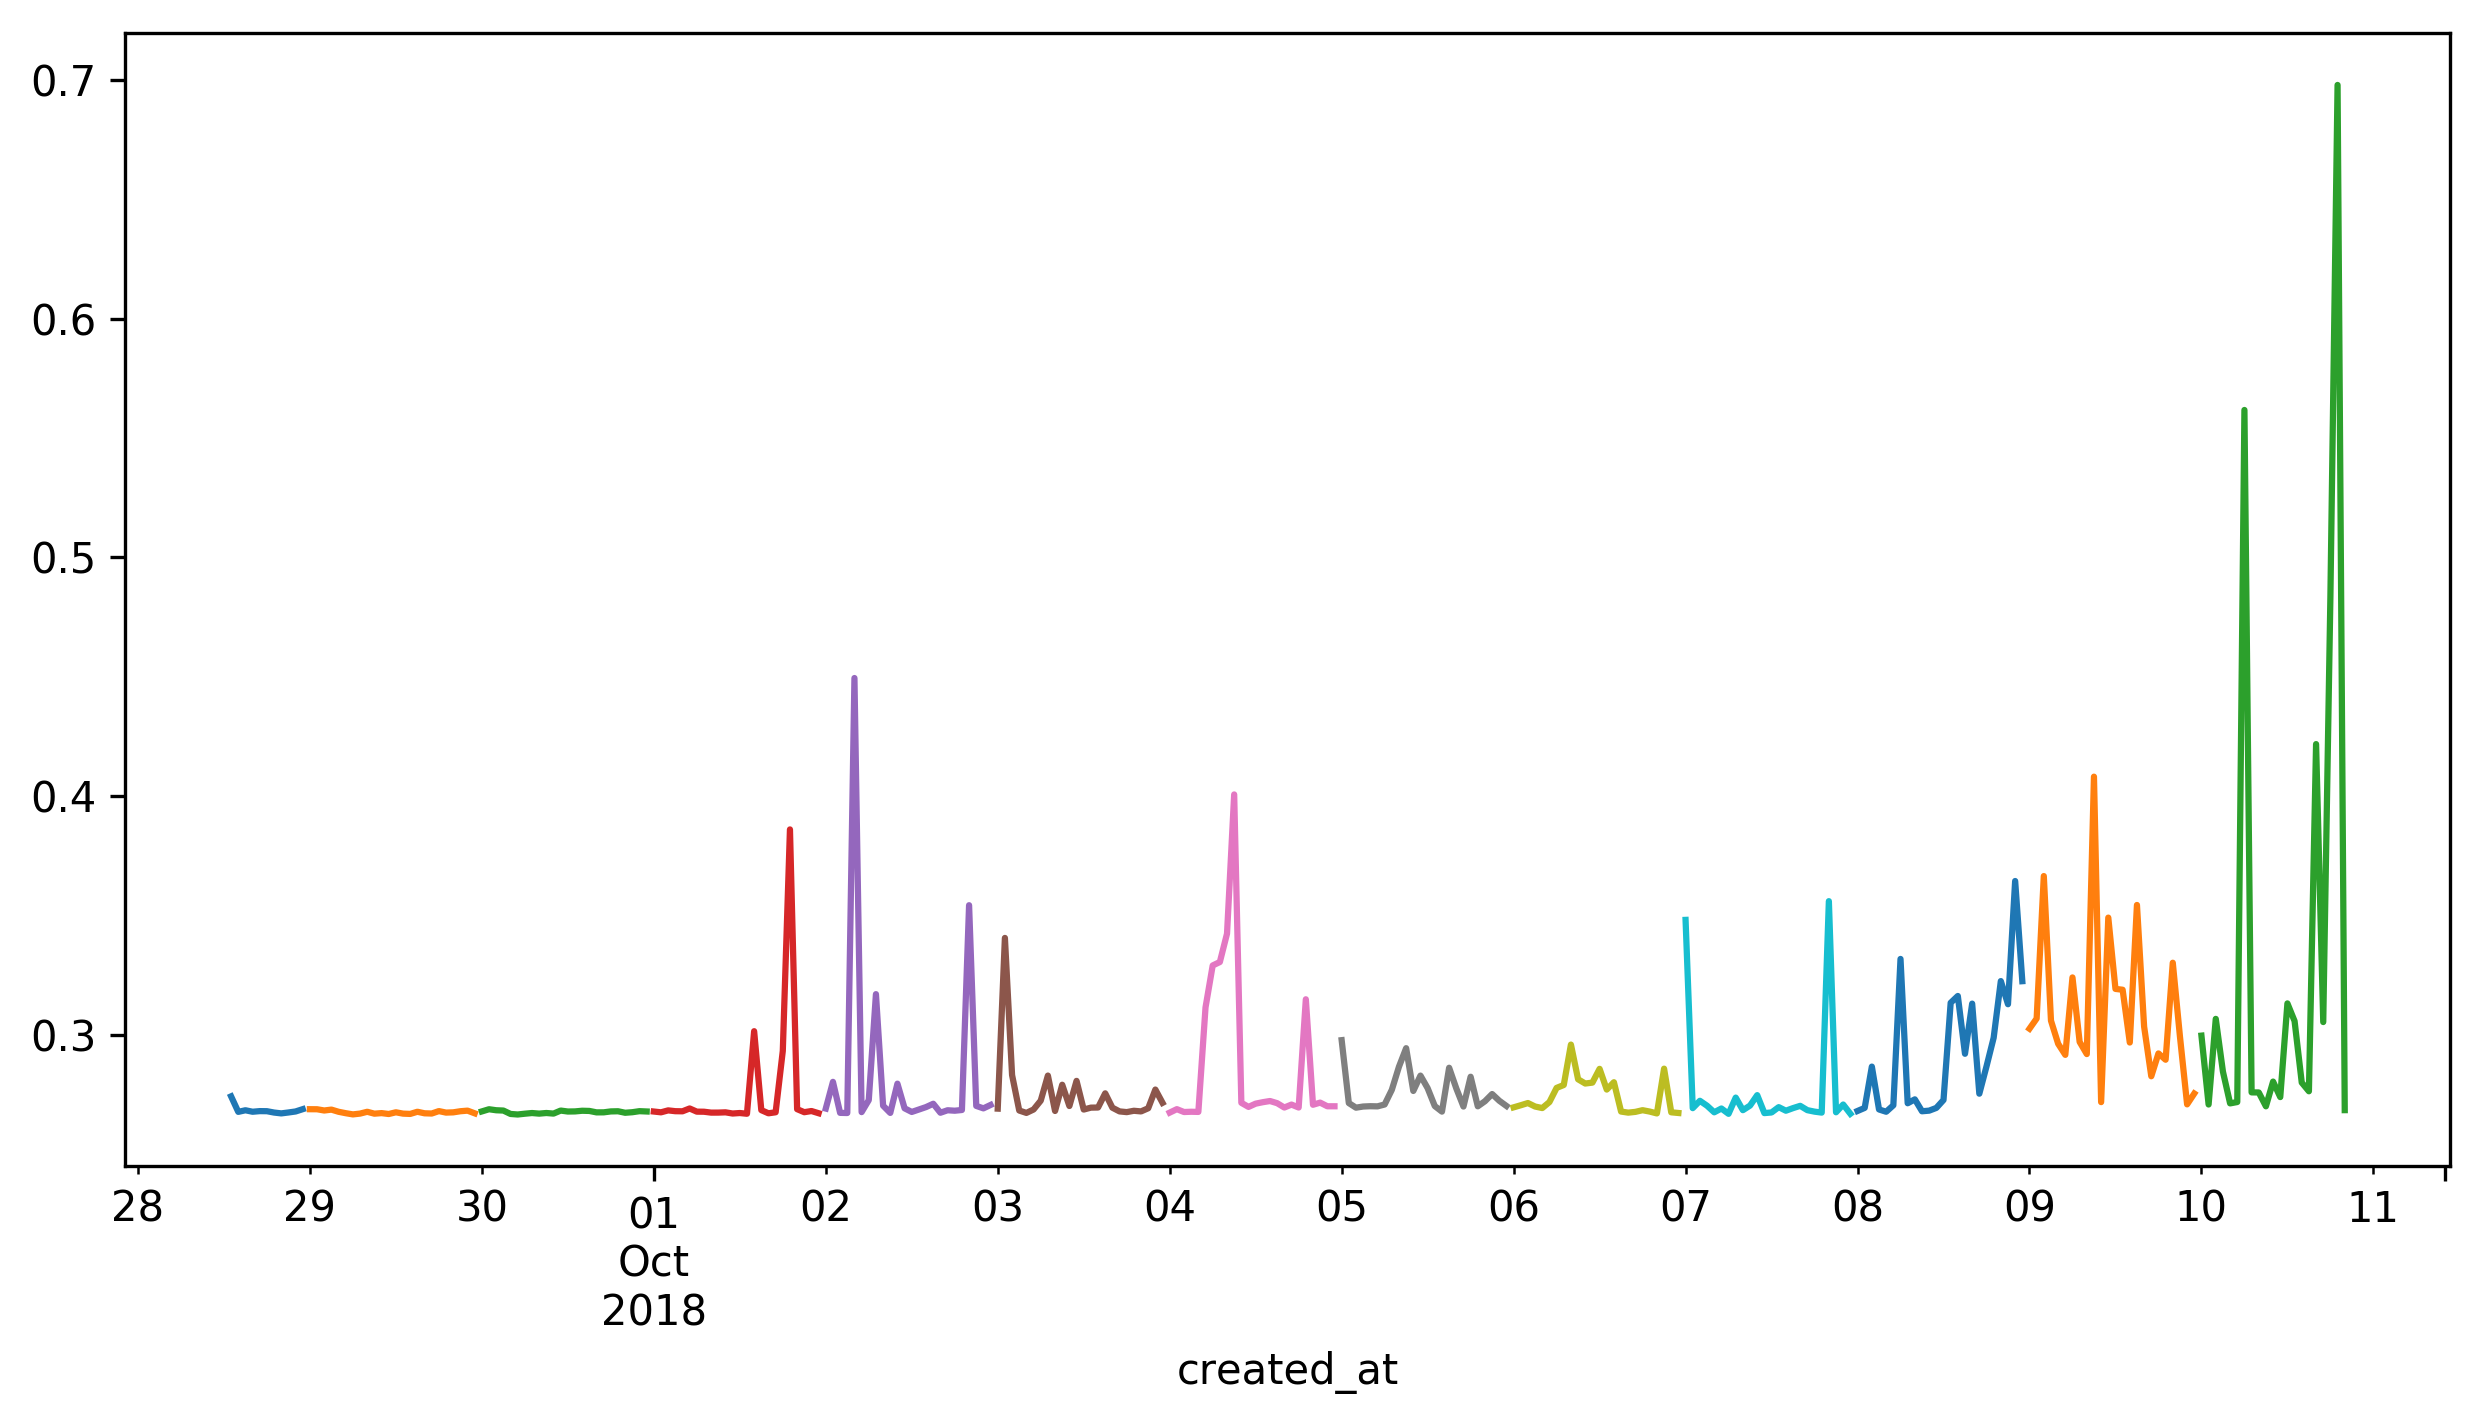

In [115]:
for i in rng:
    iolatency[str(i.year)+'-'+str(i.month)+'-'+str(i.day)].resample('H').mean().plot()

In [116]:
hrng = pd.date_range('28-9-2018', periods=13*24, freq='H')

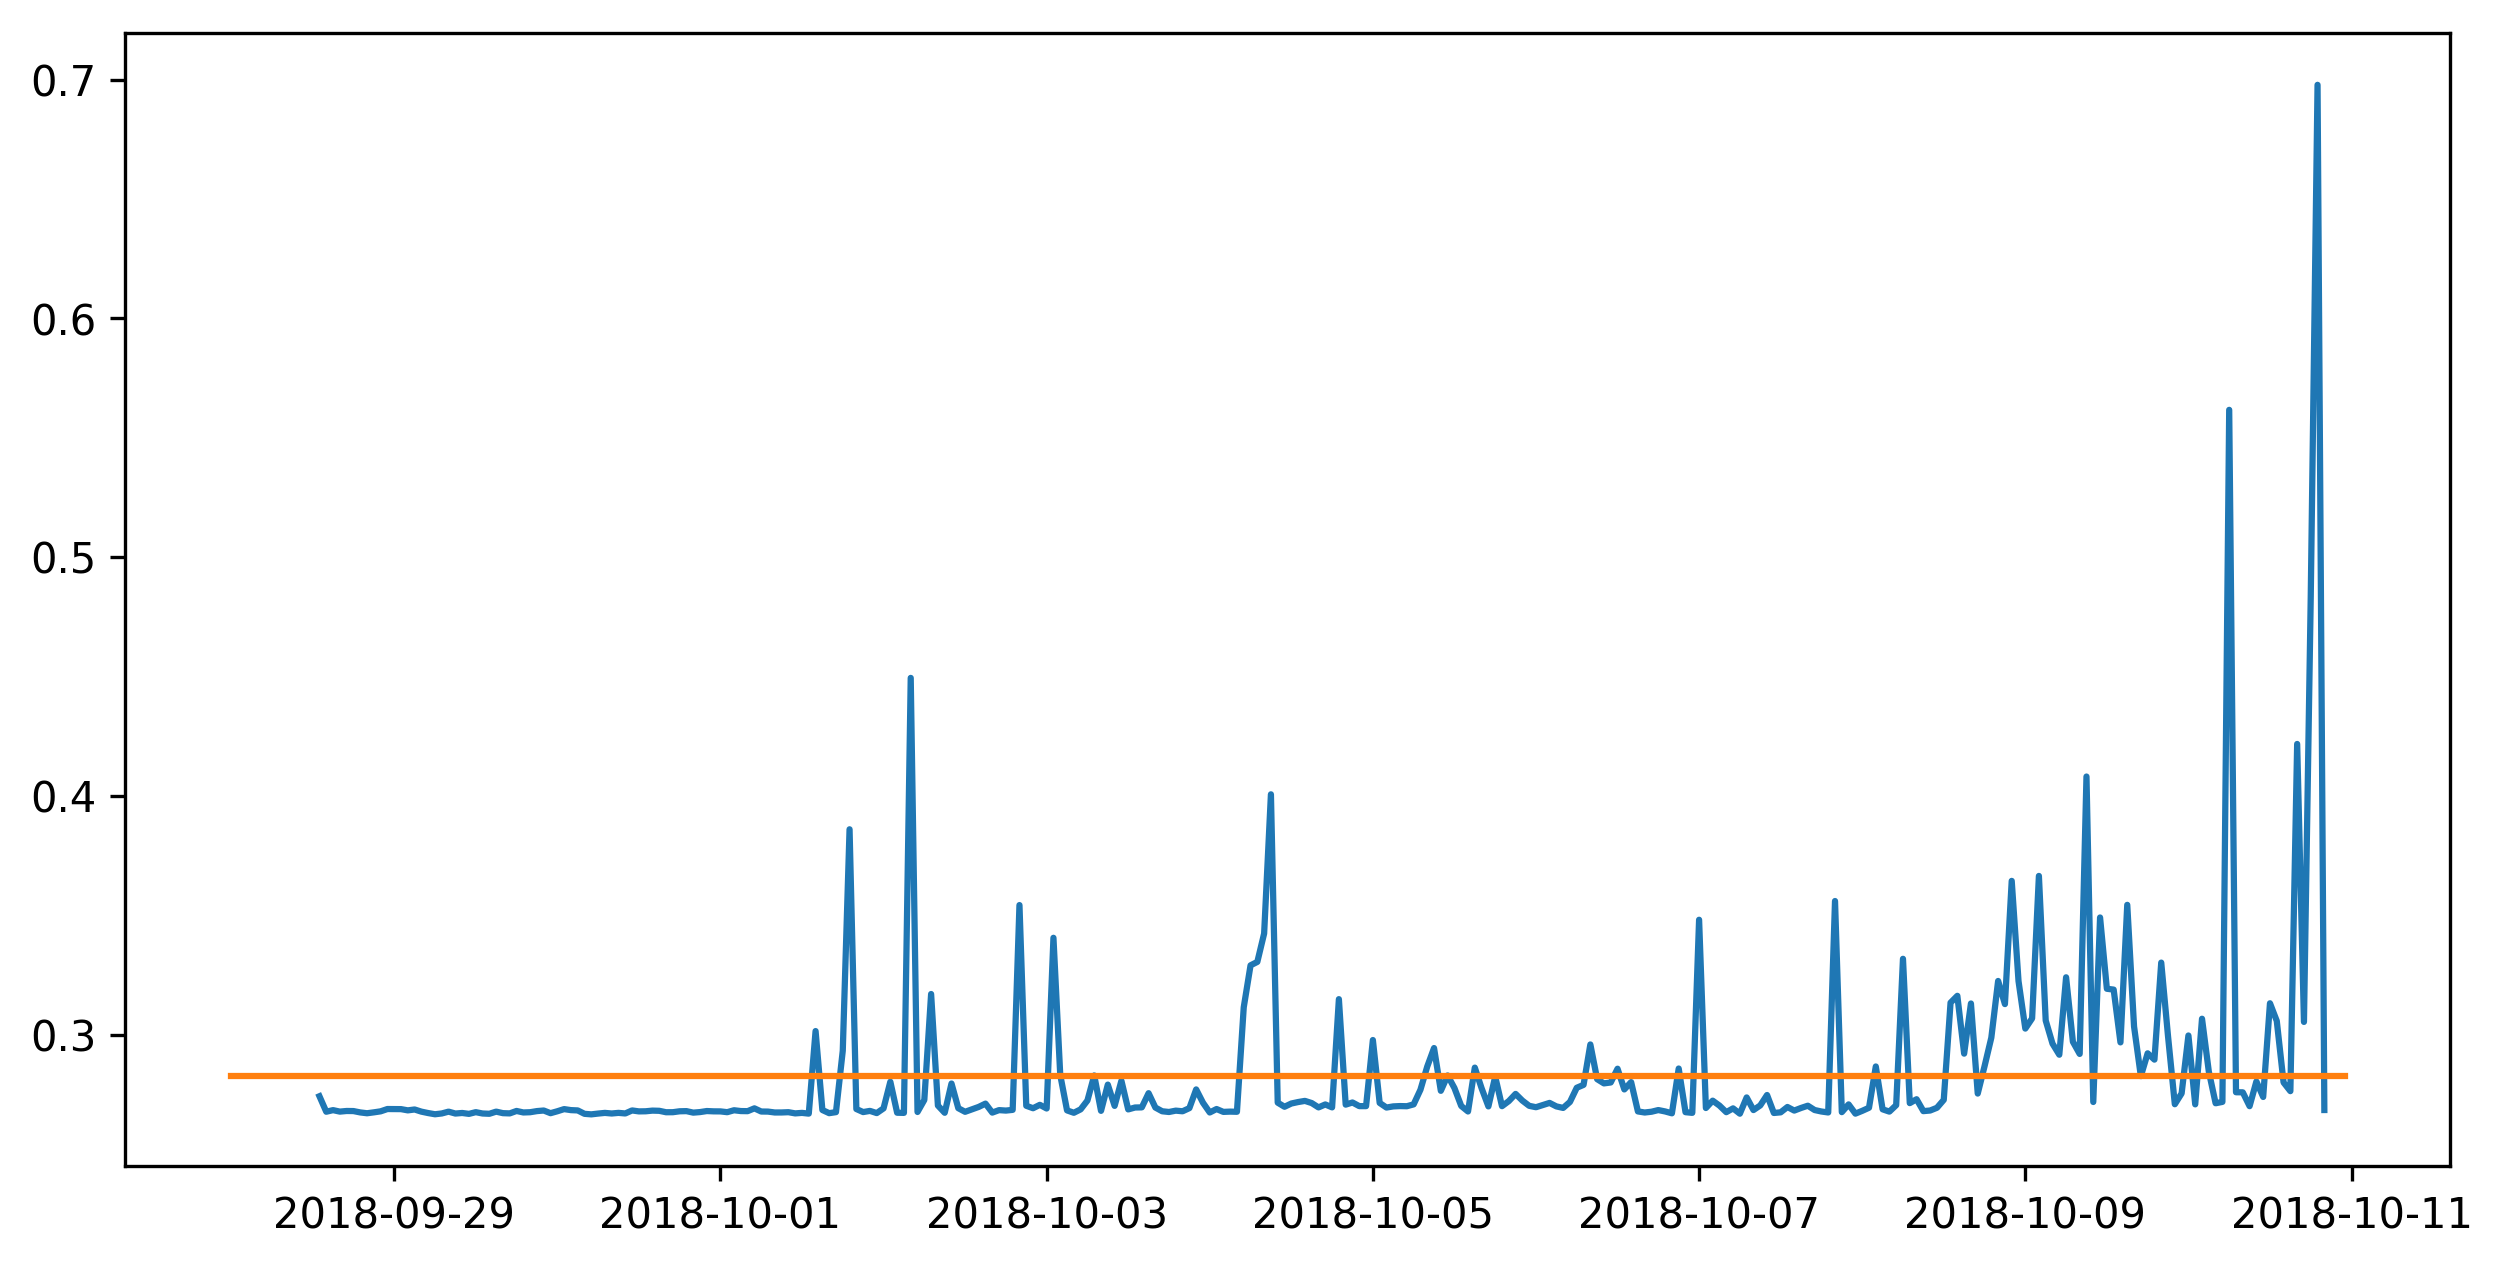

In [117]:
plt.plot(iolatency.resample('1H').mean())
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','95%')]]*len(hrng))


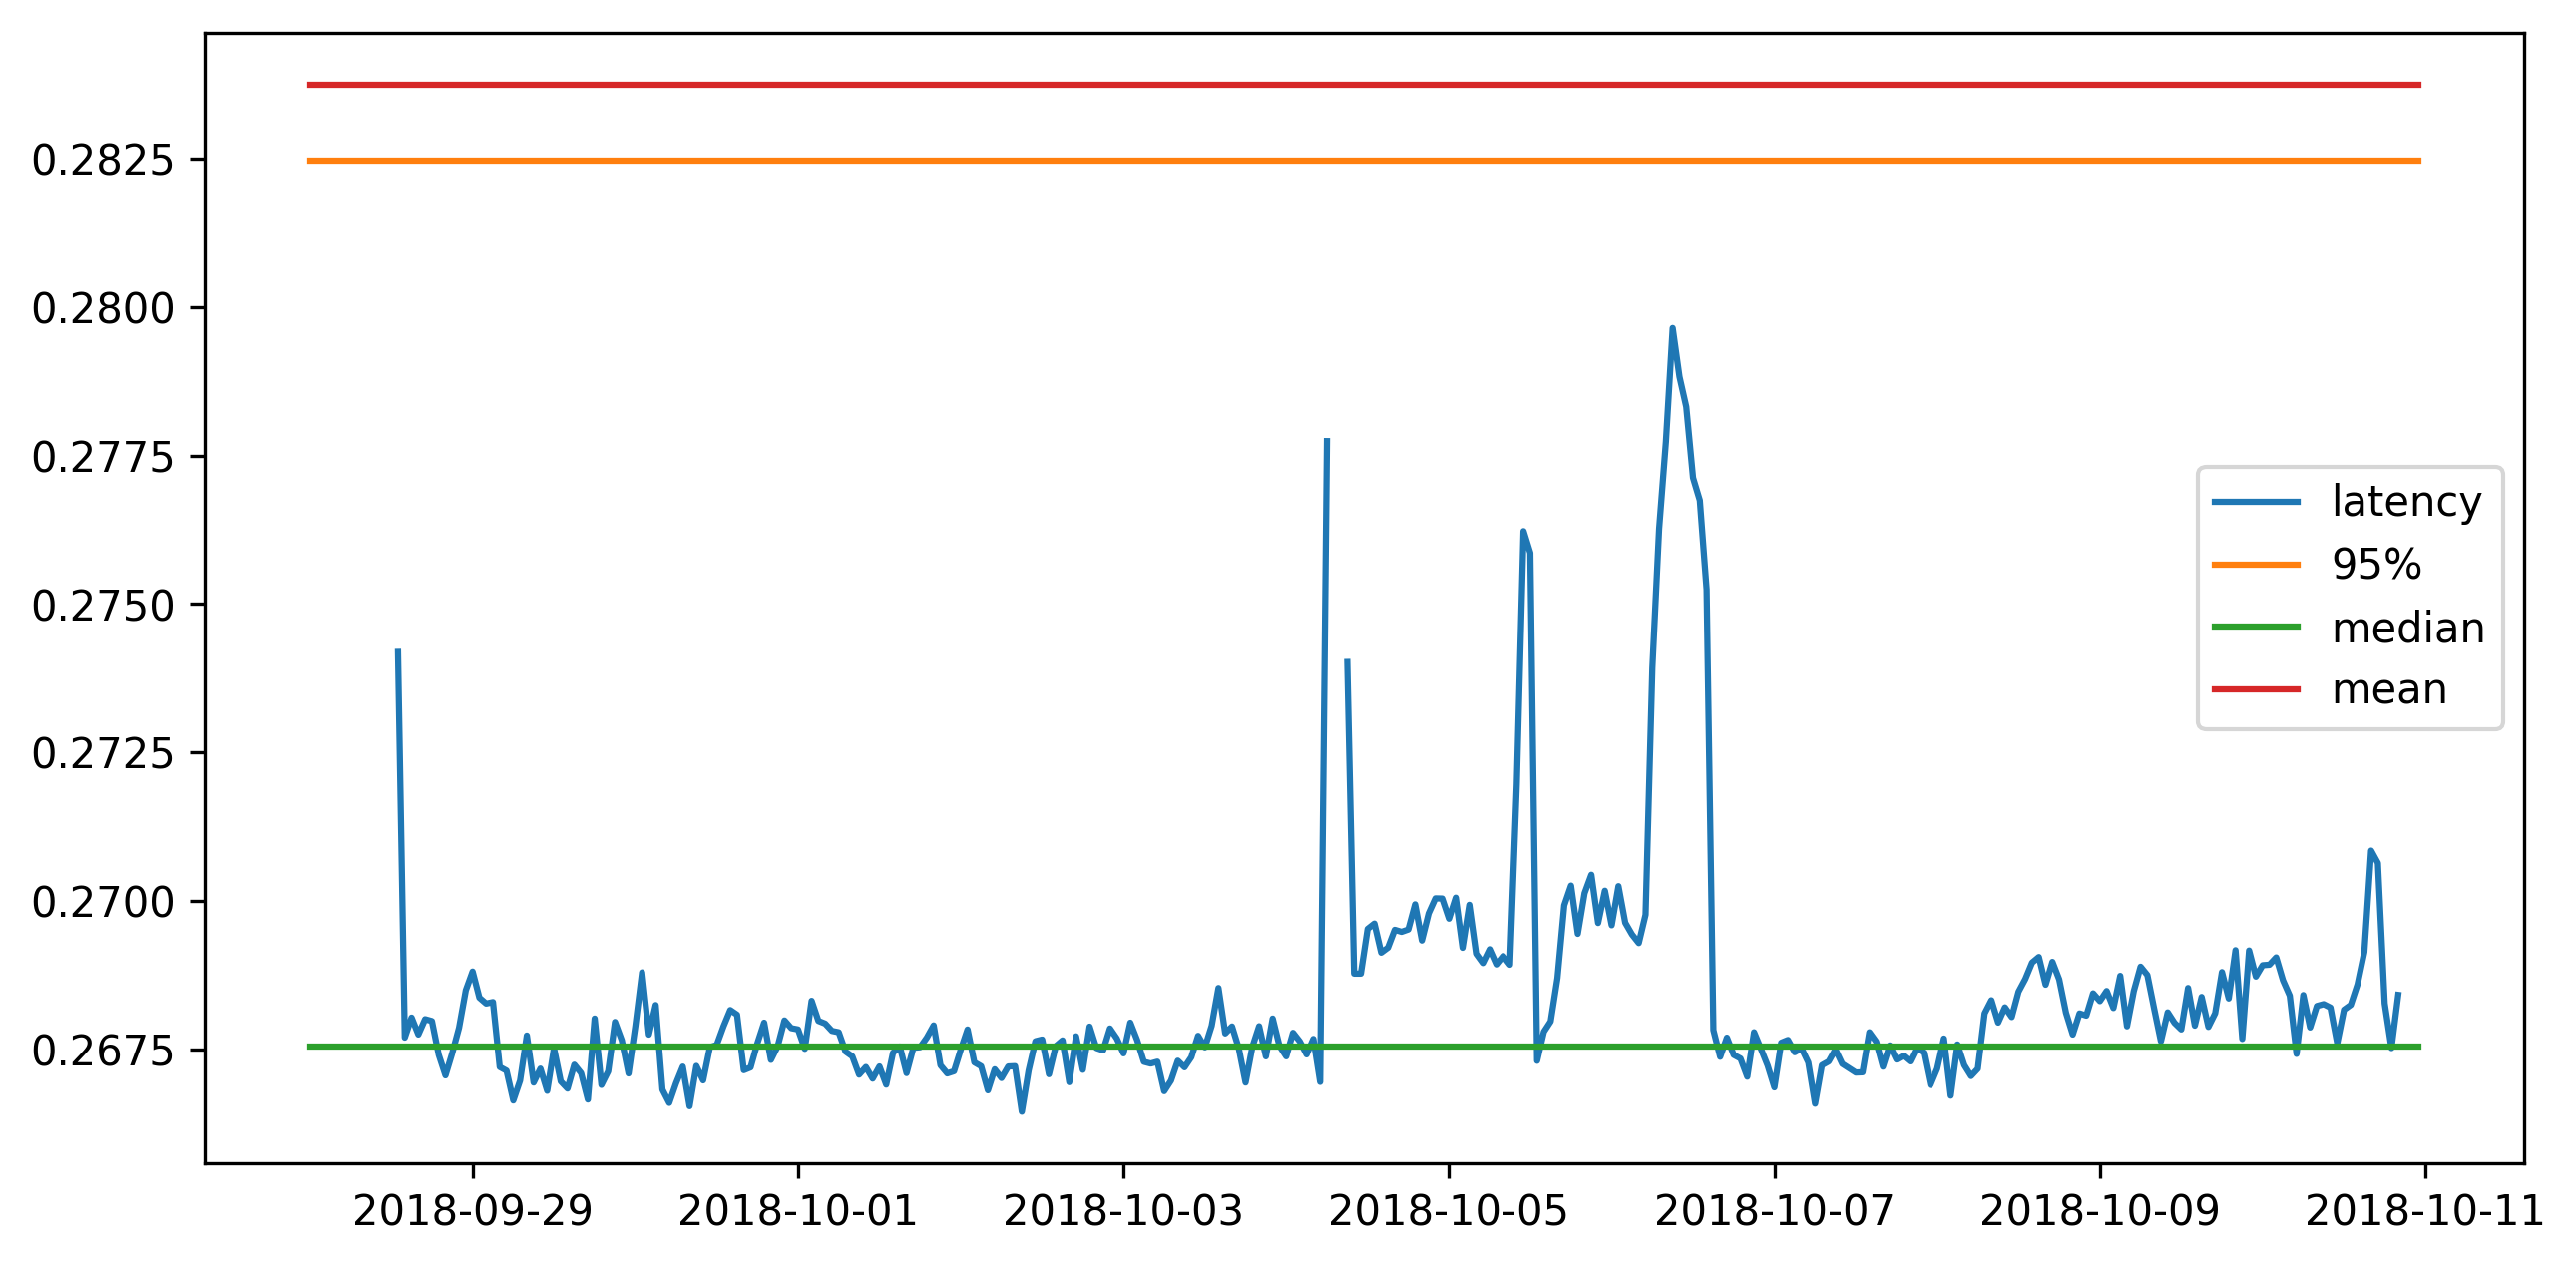

In [128]:
plt.plot(iolatency95.resample('1H').mean())
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','95%')]]*len(hrng), label='95%')
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','50%')]]*len(hrng), label='median')
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','mean')]]*len(hrng), label='mean')
plt.legend()

In [ ]:
x = np.linspace(0, 2, 100)

plt.plot(x, x, label='linear')
plt.plot(x, x**2, label='quadratic')
plt.plot(x, x**3, label='cubic')

plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Simple Plot")

plt.legend()

plt.show()